In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

from matplotlib import gridspec
from theano import tensor as tt
from scipy import stats

# Chapter 19 - Number concept development

## 19.1 Knower-level model for Give-N


$$ \pi \sim \text{Dirichlet}\overbrace{(1,...,1)}^{15} $$
$$ \nu \sim \text{Uniform}(1,1000)$$
$$ z_{i} \sim \text{Categorical}(\frac{1}{6},...,\frac{1}{6})$$  

$$ \pi^{\prime}_{ijk} \propto
\begin{cases}
\pi_k & \text{if $k \gt z_i$} \\
\nu \times \pi_{ijk} & \text{if $k \leq z_i$ and $k = q^g_{ij}$} \\
\frac{1}{\nu} \times \pi_{ijk} & \text{if $k \leq z_i$ and $k \neq q^g_{ij}$}
\end{cases}  $$  
$$ a_{ij}^g \sim \text{Categorical}(\pi^{\prime}_{ij})$$

In [2]:
import scipy.io as sio
matdata = sio.loadmat('data/fc_given.mat')

ns = np.squeeze(np.int64(matdata['ns']))
nz = np.squeeze(np.int64(matdata['nz']))
gnq = np.squeeze(np.int64(matdata['gnq']))
gn = np.squeeze(np.int64(matdata['gn']))
ga = np.squeeze(np.int64(matdata['ga']))
gq = np.squeeze(np.int64(matdata['gq']))

ind5 = np.zeros((nz, gn, gn), dtype=int)
for i in range(nz):
    i1 = i+1
    for j in range(gn):
        j1 = j+1
        for k in range(gn):
            k1 = k+1
            # Will be 1 if Knower-Level is Same or Greater than Answer
            ind1 = int(i1-1 >= k1)
            # Will be 1 for the Possible Answer that Matches the Question
            ind2 = int(k1 == j1)
            # Will be 1 for 0-Knowers
            ind3 = int(i1 == 1)
            # Will be 1 for HN-Knowers
            ind4 = int(i1 == nz)
            ind5[i, j, k] = ind3 + ind4*(2+ind2) + (1-ind4)*(1-ind3)*(ind1*ind2+ind1+1)
            

Assigned NUTS to pi_stickbreaking__
Assigned NUTS to nu_interval__
Assigned CategoricalGibbsMetropolis to zi
100%|██████████| 3500/3500.0 [00:46<00:00, 75.70it/s]


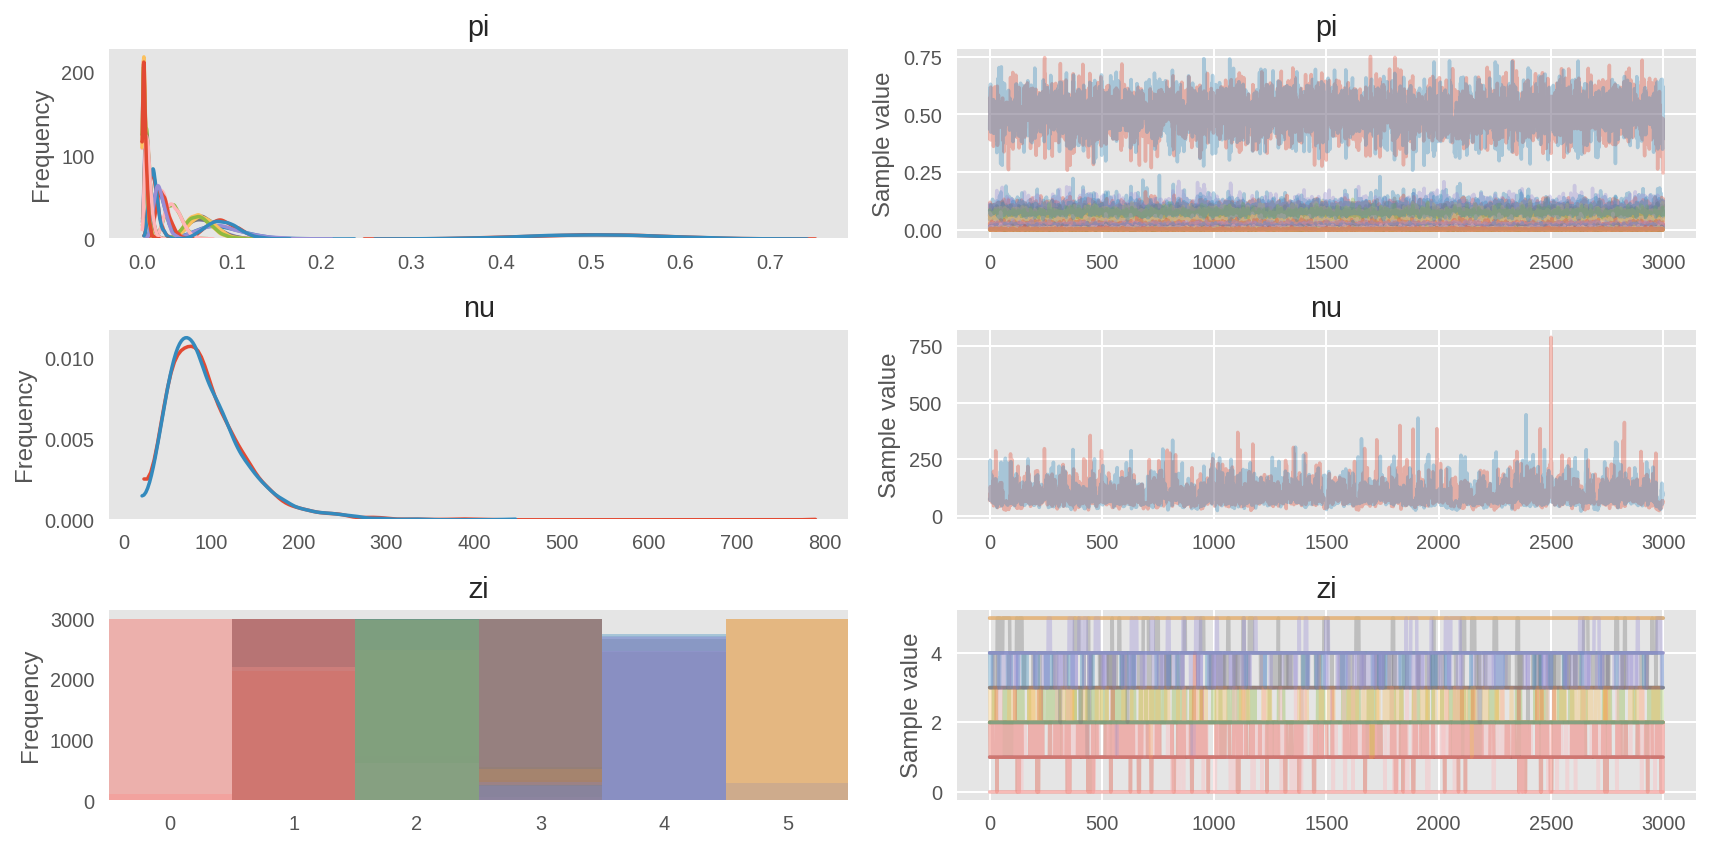

In [3]:
ind5r = ind5 - 1
ga_obs = np.asarray(ga.flatten()-1, dtype=int)
gq_obs = np.asarray(gq.flatten()-1, dtype=int)
valid_ind = np.where(gq_obs != -1)[0]

with pm.Model() as model1:
    pi = pm.Dirichlet('pi', a=np.ones(gn), shape=gn)
    
    nu = pm.Uniform('nu', lower=1, upper=1000)
    nu_vec = tt.stack([1., 1./nu, nu])
    
    piprime = tt.mul(nu_vec[ind5r], pi)
    npiprime = piprime / tt.sum(piprime, axis=-1, keepdims=True)
    
    zi = pm.Categorical('zi', p=np.ones(nz)/nz, shape=ns)
    zi_vec = tt.repeat(zi, gq.shape[1])
    
    pi_ij = npiprime[zi_vec[valid_ind], gq_obs[valid_ind], :]

    aij = pm.Categorical('aij', p=pi_ij, observed=ga_obs[valid_ind])  #, shape=len(valid_ind))  #

    trace1 = pm.sample(3e3, njobs=2)
    
pm.traceplot(trace1, varnames=['pi', 'nu', 'zi']);

The accept rate is: 0.83038
Diverge of the trace
(array([], dtype=int64),)


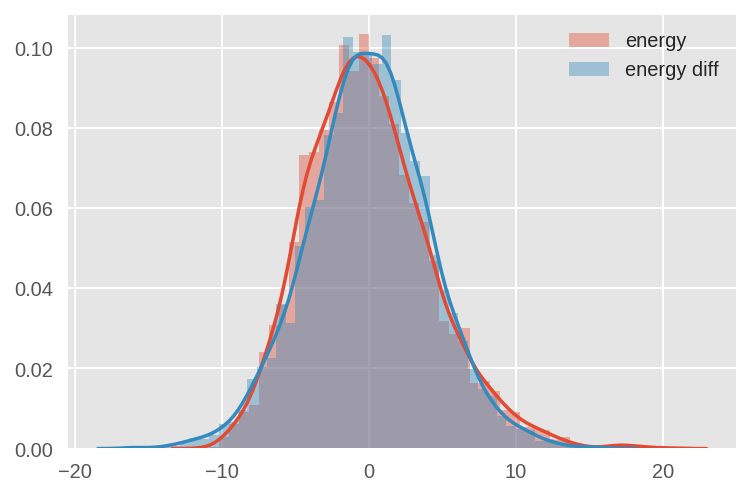

In [4]:
def plot_samplerstat(burnin,trace):
    # Sampler statistics
    accept = trace.get_sampler_stats('mean_tree_accept', burn=burnin)
    print('The accept rate is: %.5f' % (accept.mean()))
    diverge = trace.get_sampler_stats('diverging', burn=burnin)
    print('Diverge of the trace')
    print(diverge.nonzero())
    energy = trace.get_sampler_stats('energy', burn=burnin)
    energy_diff = np.diff(energy)
    sns.distplot(energy - energy.mean(), label='energy')
    sns.distplot(energy_diff, label='energy diff')
    plt.legend()
    plt.show()
    
burnin = 1000
plot_samplerstat(burnin,trace1)

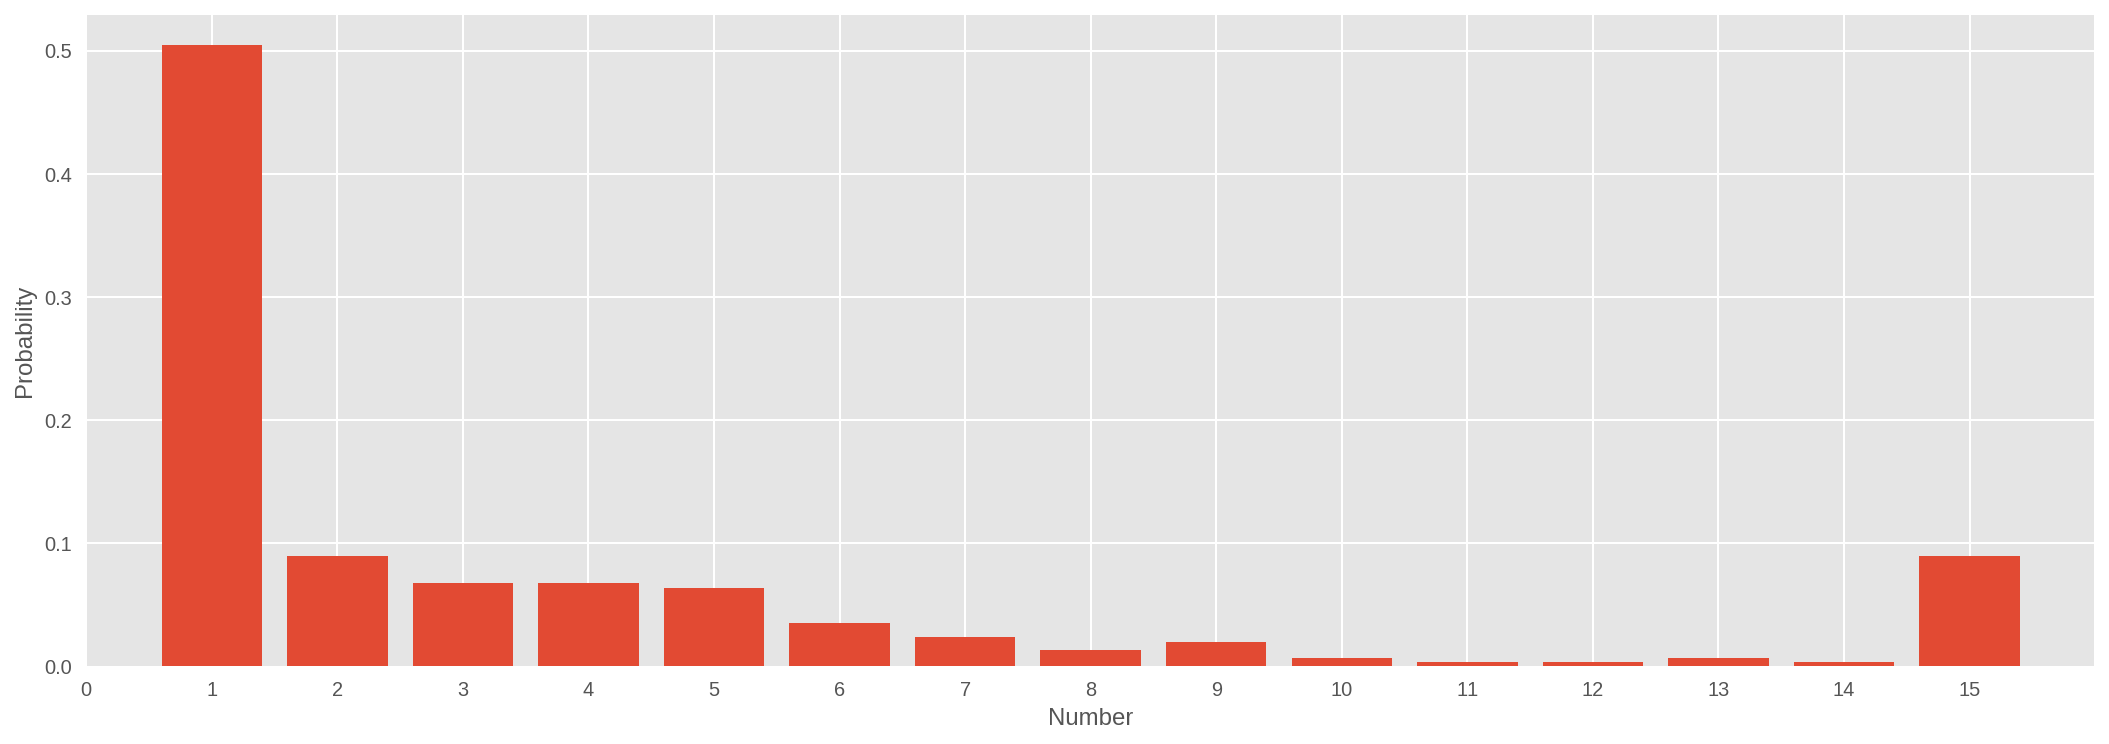

In [5]:
pitr = trace1[burnin:]['pi']
fig = plt.figure(figsize=(18, 6))
plt.bar(np.arange(15)+1, np.mean(pitr, axis=0), align='center')
plt.xlabel('Number')
plt.ylabel('Probability')
plt.xticks(np.arange(16))
plt.xlim([0, 16])
plt.show()

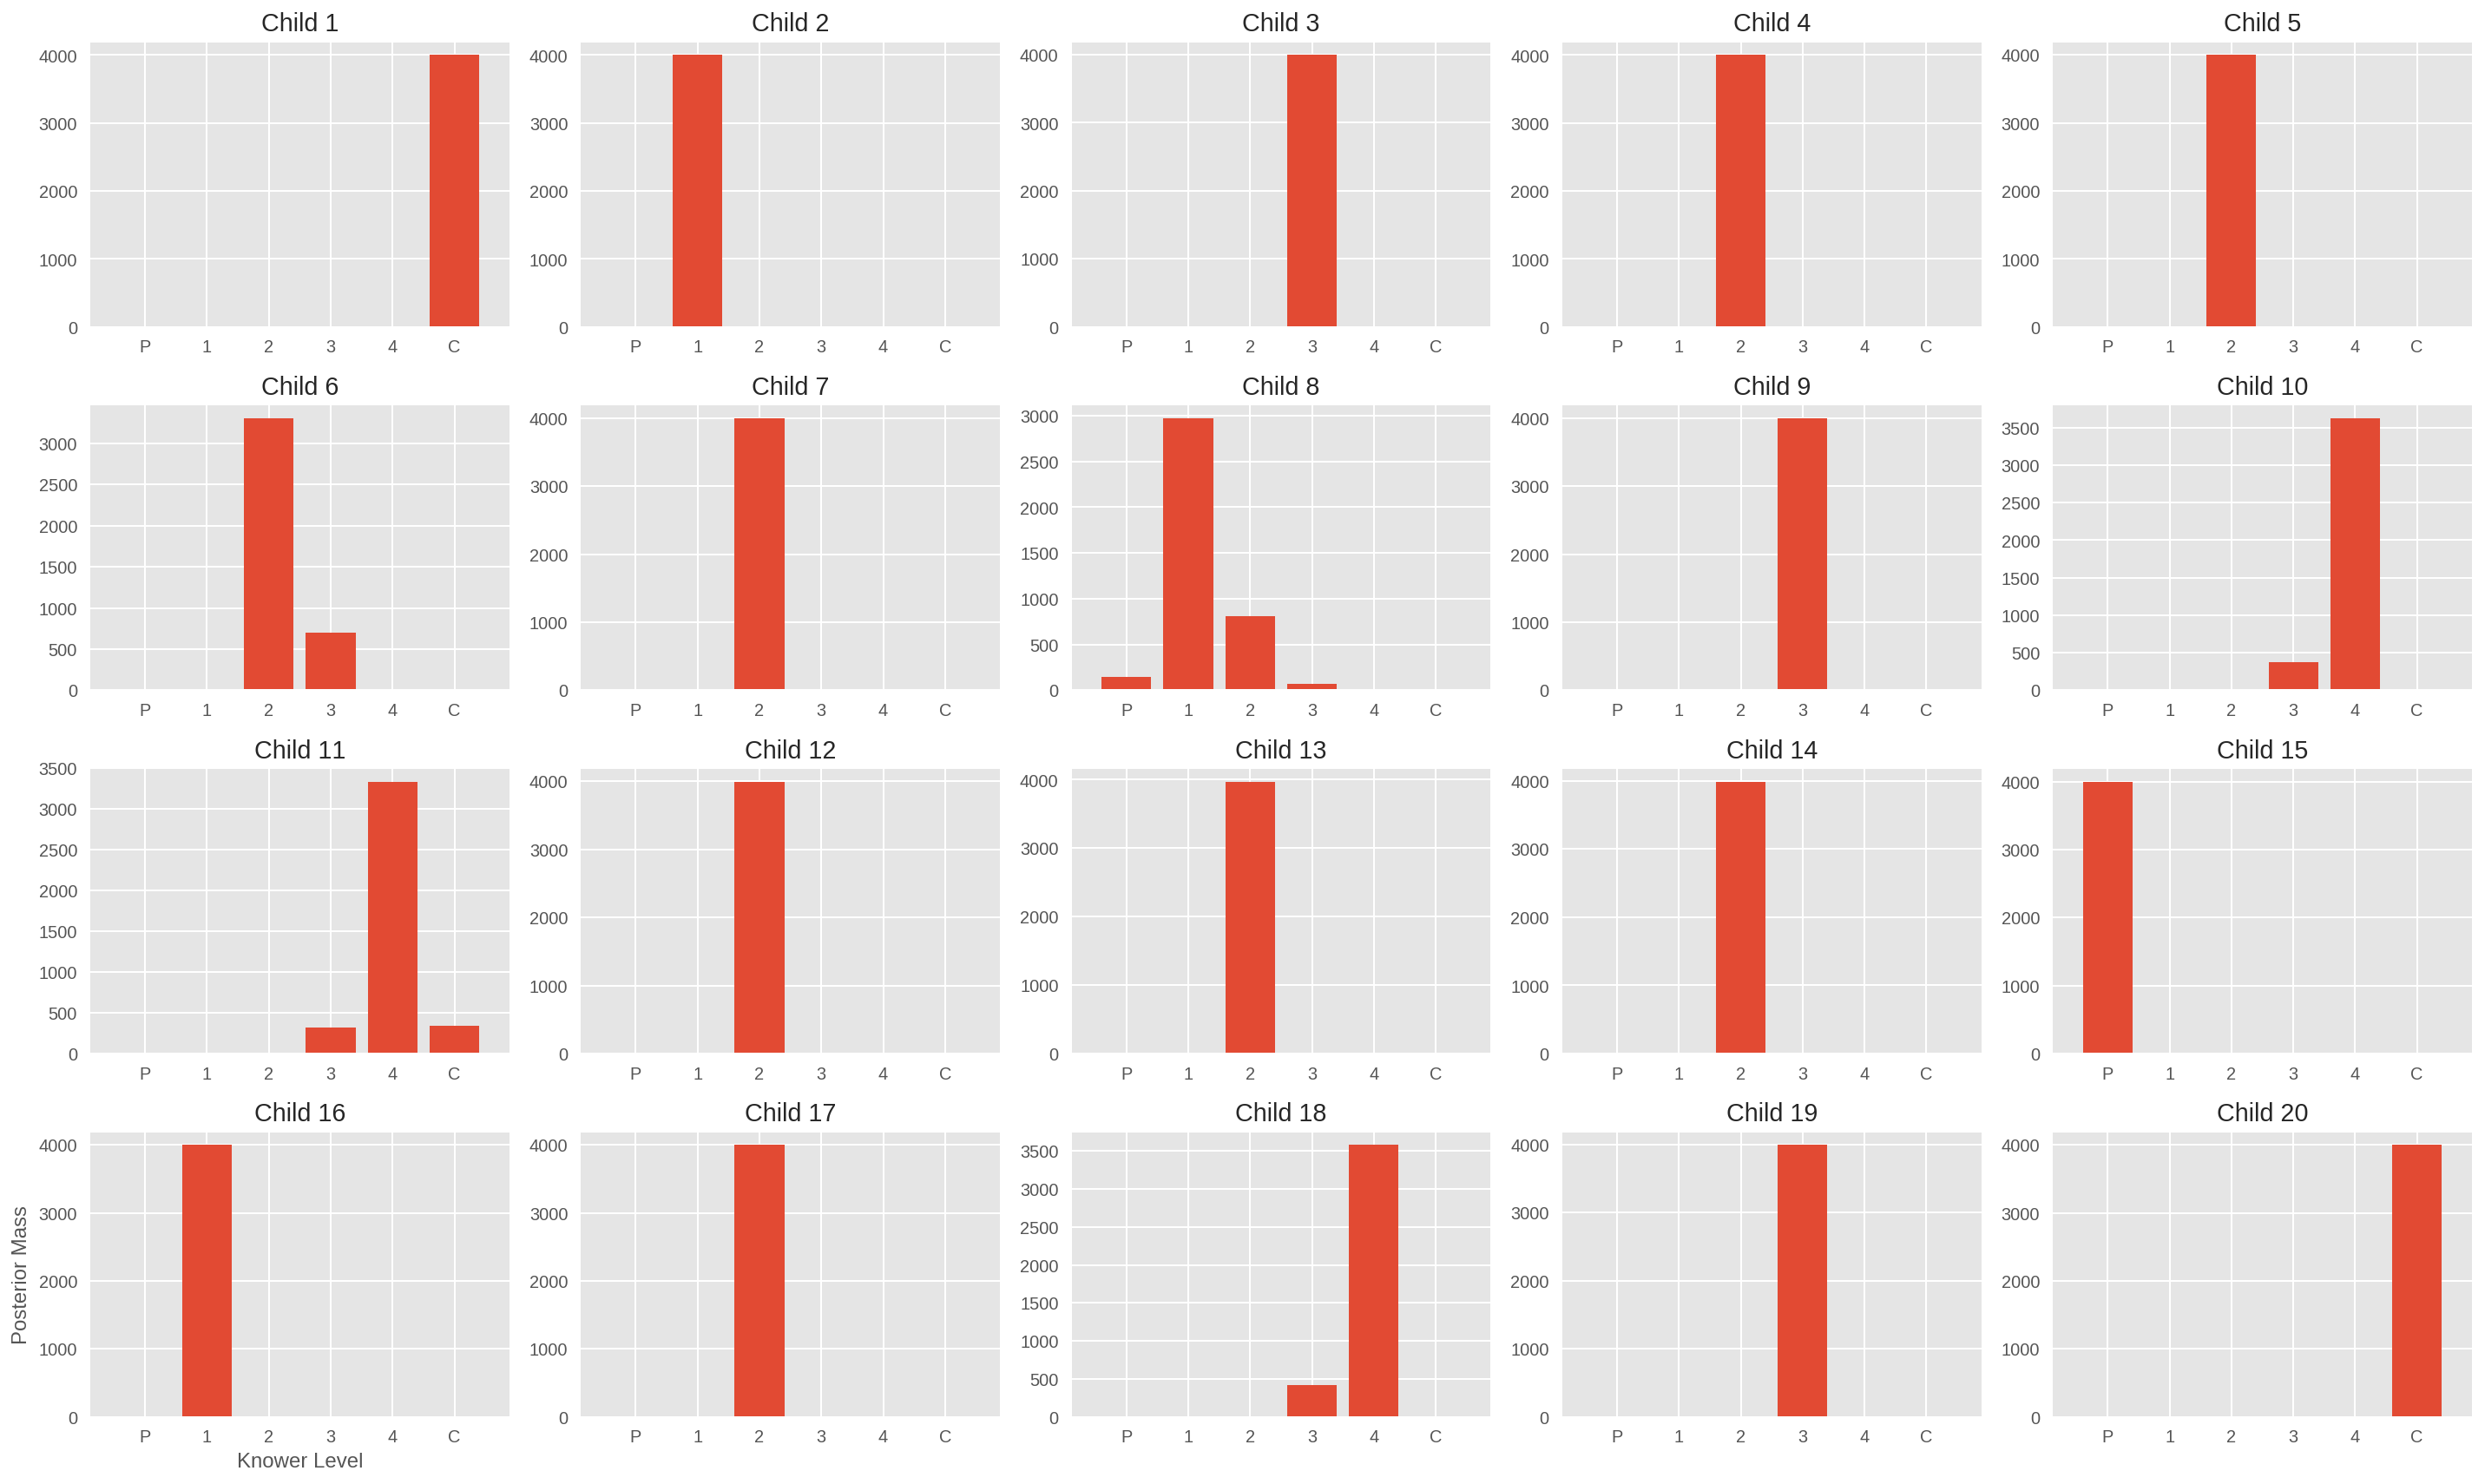

In [6]:
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(4, 5)
zitr = trace1[burnin:]['zi']
for i in range(ns):
    ax = plt.subplot(gs[i])
    bartmp = np.unique(zitr[:, i], return_counts=True)
    ax.bar(bartmp[0], bartmp[1])
    ax.set_title('Child %s'%(i+1))
    plt.xlim([-.9, 5.9])
    plt.xticks(np.arange(6), ['P', '1', '2', '3', '4', 'C'])
    
plt.subplot(gs[15])
plt.xlabel('Knower Level')
plt.ylabel('Posterior Mass')
plt.tight_layout()
plt.show()

In [7]:
# Generate posterior prediction for each subject
gqpred = np.tile(np.arange(gn)[np.newaxis, :], (ns, 1)).flatten()

# Generate posterior prediction for each knower level
zpred = np.tile(np.arange(gn)[np.newaxis, :], (nz, 1)).flatten()
z_vect = np.tile(np.arange(nz)[:, np.newaxis], (1, gn)).flatten()

nutr = trace1[burnin:]['nu']
tracelen = nutr.shape[0]
nsample = 500
predga = np.zeros((nsample, len(gqpred)))
predz = np.zeros((nsample, len(zpred)))
randlist = np.random.choice(tracelen, nsample)
caterandom = lambda p: np.asarray([np.random.choice(len(p1), p=p1) for p1 in p])
for i, idx in enumerate(randlist):
    pi1, nu1, zi1 = pitr[idx], nutr[idx], zitr[idx]
    
    nu_vec1 = np.stack([1., 1./nu1, nu1])
    piprime1 = np.multiply(nu_vec1[ind5r], pi1)
    npiprime1 = piprime1 / np.sum(piprime1, axis=-1, keepdims=True)
    
    zi_vec2 = np.repeat(zi1, gn)
    pi_ij_pred = npiprime1[zi_vec2, gqpred, :]
    predga[i, :] = caterandom(pi_ij_pred)

    zi_ij_pred = npiprime1[z_vect, zpred, :]
    predz[i, :] = caterandom(zi_ij_pred)

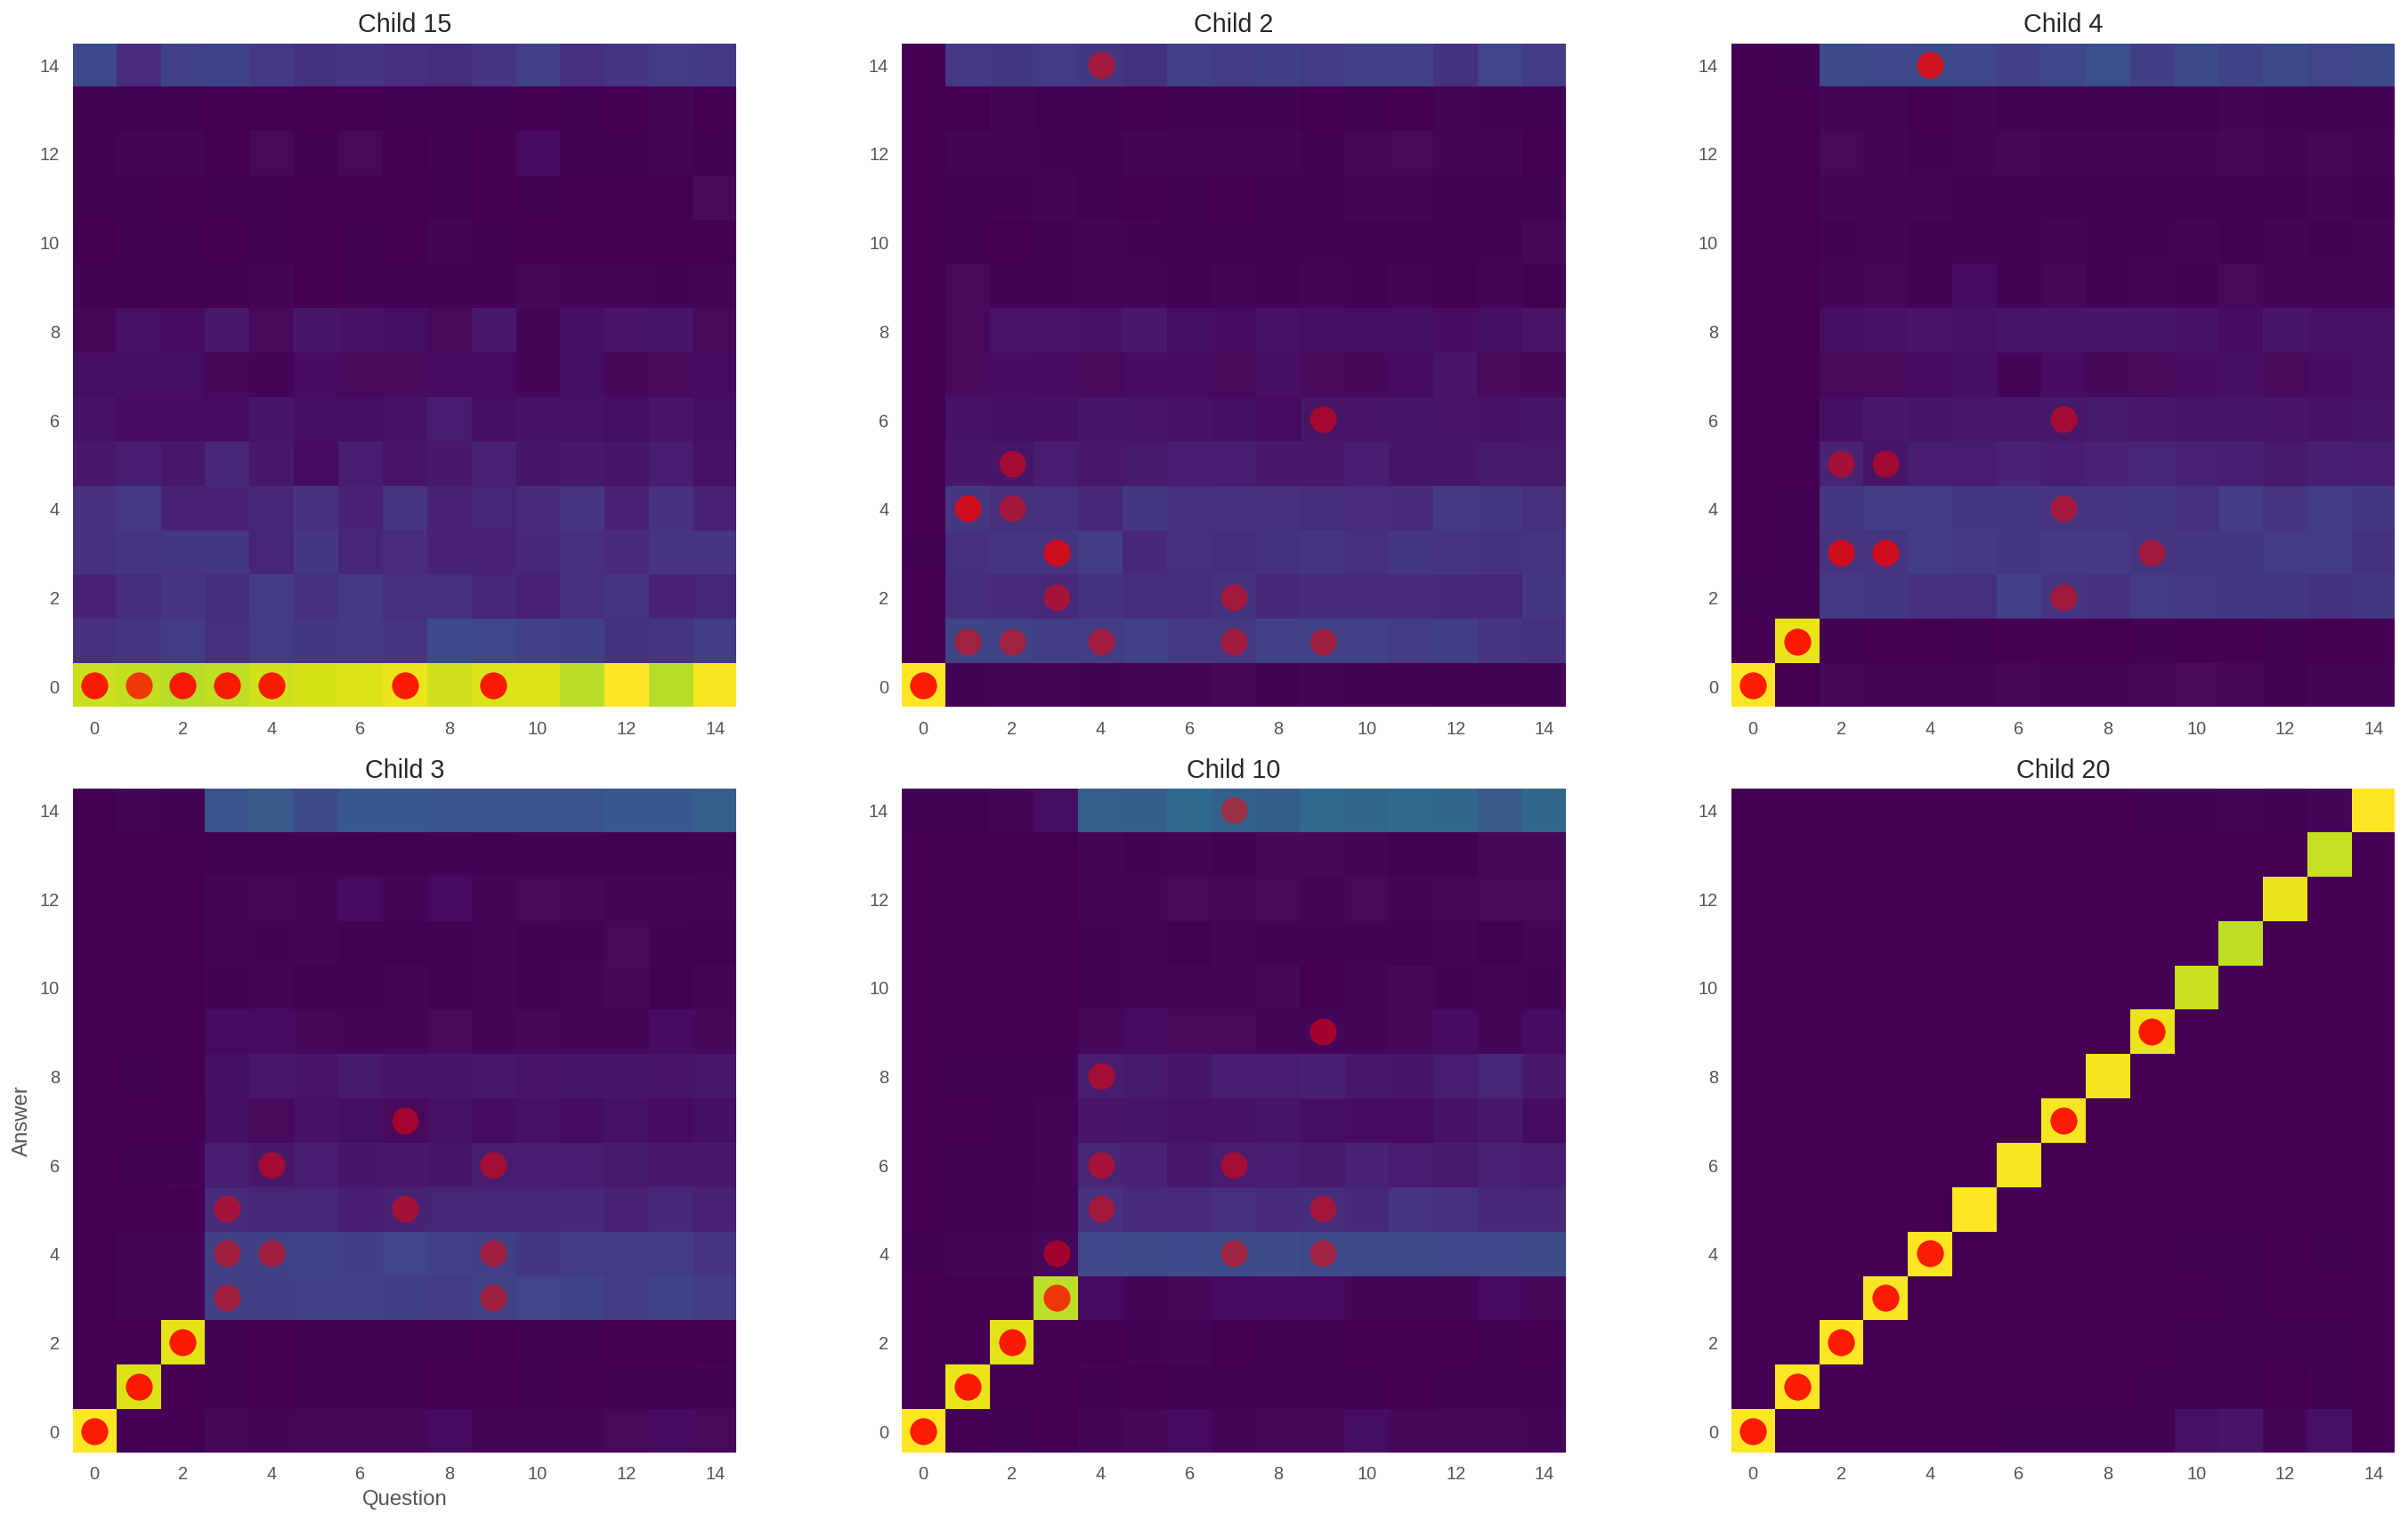

In [8]:
predga = np.reshape(predga, newshape=(nsample, ns, gn)).astype(int)

fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2, 3)
subjlist = np.asarray([15, 2, 4, 3, 10, 20])-1
for i, isbj in enumerate(subjlist):
    mattmp = np.squeeze(predga[:, isbj, :])
    obs = ga[isbj]-1
    qus = gq[isbj]-1
    msk = qus != -1
    img_ = np.zeros((gn, gn))
    for j in range(gn):
        bartmp = np.unique(mattmp[:, j], return_counts=True)
        img_[j, bartmp[0]] = bartmp[1]
    ax = plt.subplot(gs[i])
    ax.imshow(img_.T, cmap='viridis', origin='lower')
    ax.plot(qus[msk], obs[msk], 'o', ms=15, color='r', alpha=.5)
    ax.grid('off')
    ax.set_title('Child %s'%(isbj+1))

plt.subplot(gs[3])
plt.xlabel('Question')
plt.ylabel('Answer')
plt.tight_layout()
plt.show()

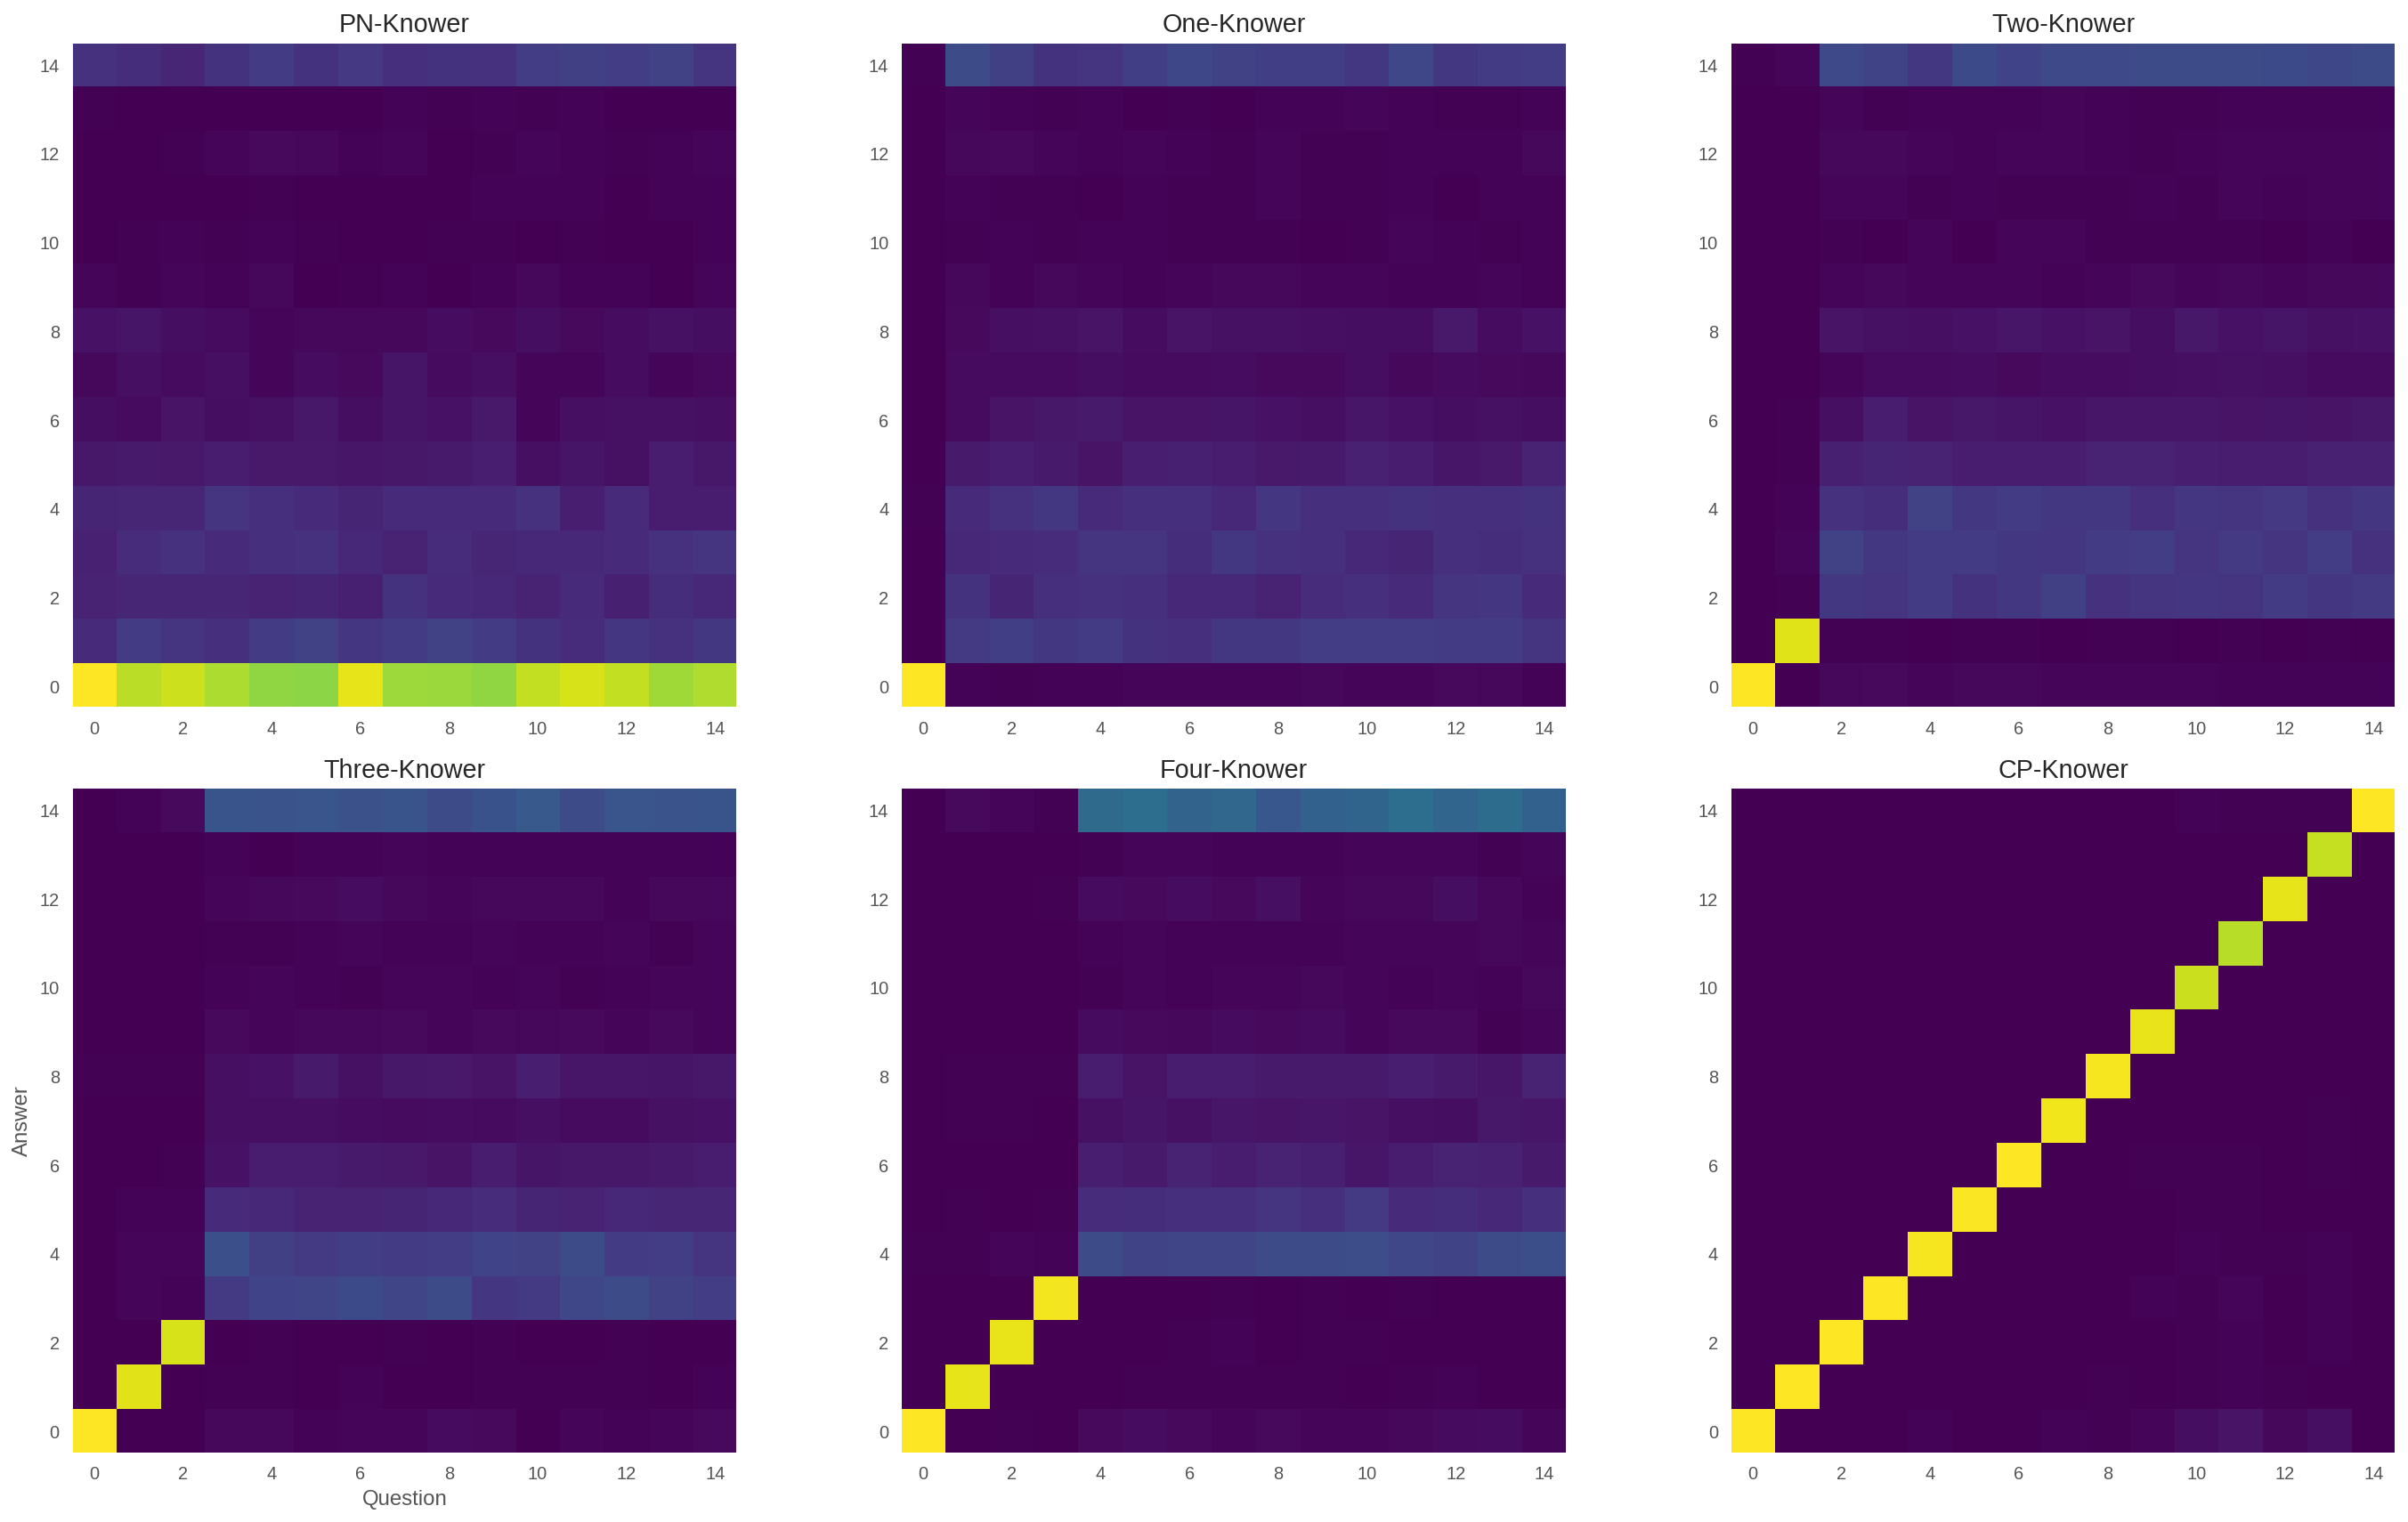

In [9]:
predz = np.reshape(predz, newshape=(nsample, nz, gn)).astype(int)

fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2, 3)
knowertype = ('PN-Knower', 'One-Knower', 'Two-Knower',
              'Three-Knower', 'Four-Knower', 'CP-Knower')
for i in range(nz):
    mattmp = np.squeeze(predz[:, i, :])
    img_ = np.zeros((gn, gn))
    for j in range(gn):
        bartmp = np.unique(mattmp[:, j], return_counts=True)
        img_[j, bartmp[0]] = bartmp[1]
    ax = plt.subplot(gs[i])
    ax.imshow(img_.T, cmap='viridis', origin='lower')
    ax.grid('off')
    ax.set_title(knowertype[i])

plt.subplot(gs[3])
plt.xlabel('Question')
plt.ylabel('Answer')
plt.tight_layout()
plt.show()

## 19.2 Knower-level model for Fast-Cards


$$ \pi \sim \text{Dirichlet}\overbrace{(1,...,1)}^{50} $$
$$ \nu \sim \text{Uniform}(1,1000)$$
$$ z_{i} \sim \text{Categorical}(\frac{1}{6},...,\frac{1}{6})$$  

$$ \pi^{\prime}_{ijk} \propto
\begin{cases}
\pi_k & \text{if $k \gt z_i$} \\
\nu \times \pi_{ijk} & \text{if $k \leq z_i$ and $k = q^f_{ij}$} \\
\frac{1}{\nu} \times \pi_{ijk} & \text{if $k \leq z_i$ and $k \neq q^f_{ij}$}
\end{cases}  $$  
$$ a_{ij}^f \sim \text{Categorical}(\pi^{\prime}_{ij})$$

In [10]:
fnq = np.squeeze(np.int64(matdata['fnq']))
fa = np.squeeze(np.int64(matdata['fa']))
fq = np.squeeze(np.int64(matdata['fq']))
fn = 50

find5 = np.zeros((nz, gn, fn), dtype=int)
for i in range(nz):
    i1 = i+1
    for j in range(gn):
        j1 = j+1
        for k in range(fn):
            k1 = k+1
            # Will be 1 if Knower-Level is Same or Greater than Answer
            find1 = int(i1-1 >= k1)
            # Will be 1 for the Possible Answer that Matches the Question
            find2 = int(k1 == j1)
            # Will be 1 for 0-Knowers
            find3 = int(i1 == 1)
            # Will be 1 for HN-Knowers
            find4 = int(i1 == nz)
            find5[i, j, k] = find3 + find4*(2+find2) + (1-find4)*(1-find3)*(find1*find2+find1+1)

Assigned NUTS to pi_stickbreaking__
Assigned NUTS to nu_interval__
Assigned CategoricalGibbsMetropolis to zi
100%|██████████| 3500/3500.0 [03:03<00:00, 18.64it/s]


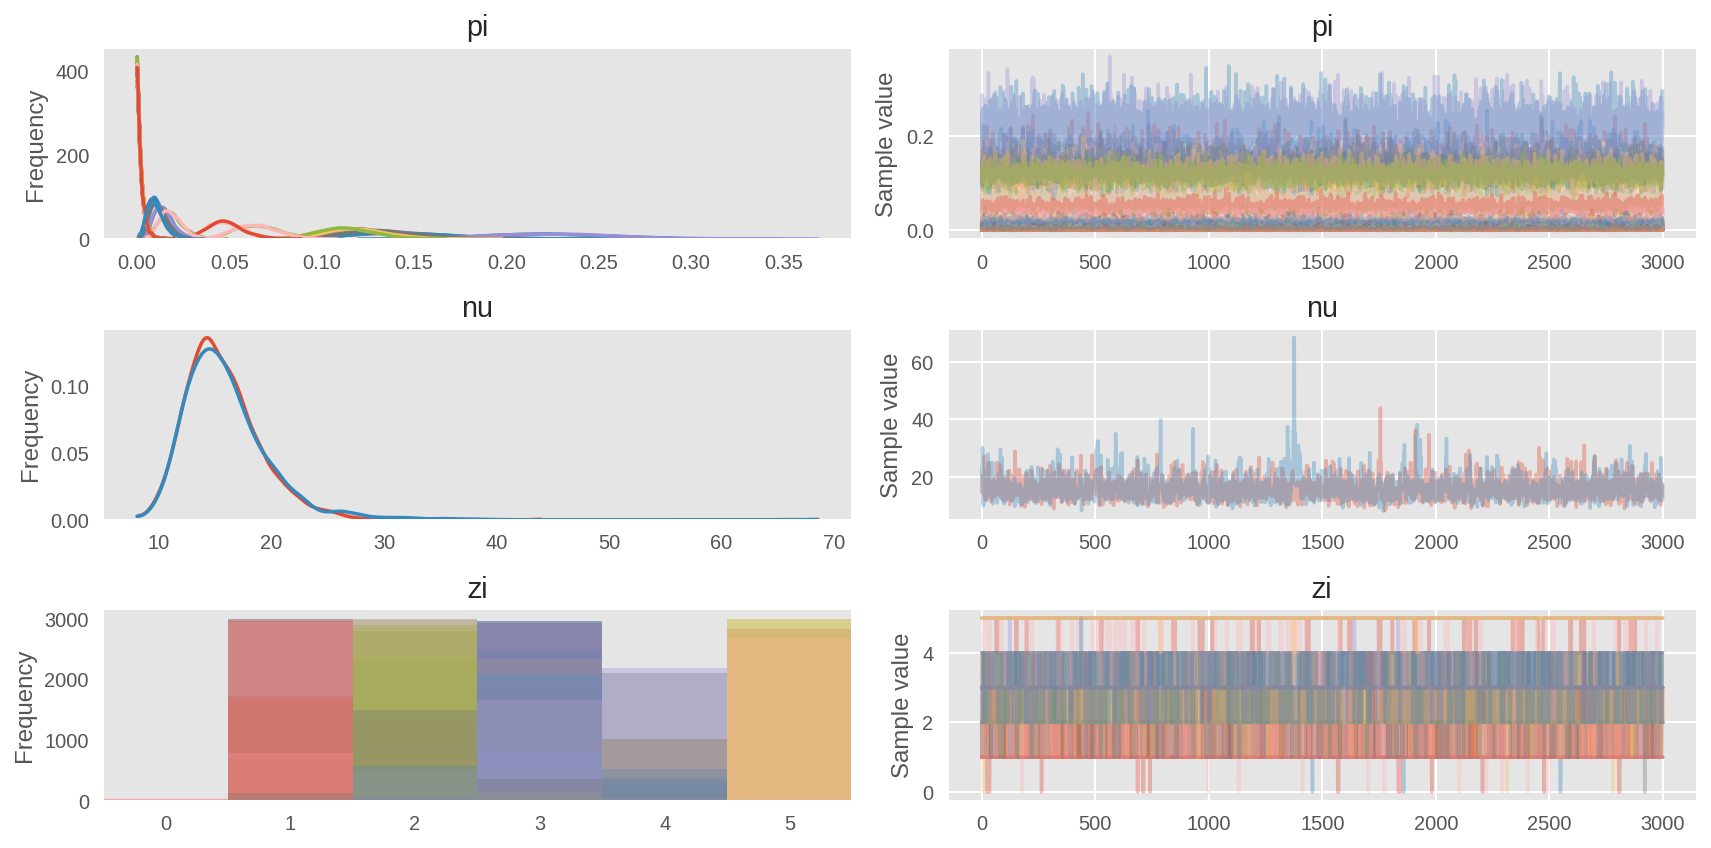

In [11]:
find5r = find5 - 1
fa_obs = np.asarray(fa.flatten()-1, dtype=int)
fq_obs = np.asarray(fq.flatten()-1, dtype=int)
valid_ind2 = np.where(fq_obs != -1)[0]

with pm.Model() as model2:
    pi = pm.Dirichlet('pi', a=np.ones(fn), shape=fn)
    
    nu = pm.Uniform('nu', lower=1, upper=1000)
    nu_vec = tt.stack([1., 1./nu, nu])
    
    piprime = tt.mul(nu_vec[find5r], pi)
    npiprime = piprime / tt.sum(piprime, axis=-1, keepdims=True)
    
    zi = pm.Categorical('zi', p=np.ones(nz)/nz, shape=ns)
    zi_vec = tt.repeat(zi, fq.shape[1])
    
    pi_ij = npiprime[zi_vec[valid_ind2], fq_obs[valid_ind2], :]

    aij = pm.Categorical('aij', p=pi_ij, observed=fa_obs[valid_ind2])  #, shape=len(valid_ind))  #

    trace2 = pm.sample(3e3, njobs=2)
    
pm.traceplot(trace2, varnames=['pi', 'nu', 'zi']);

The accept rate is: 0.82900
Diverge of the trace
(array([], dtype=int64),)


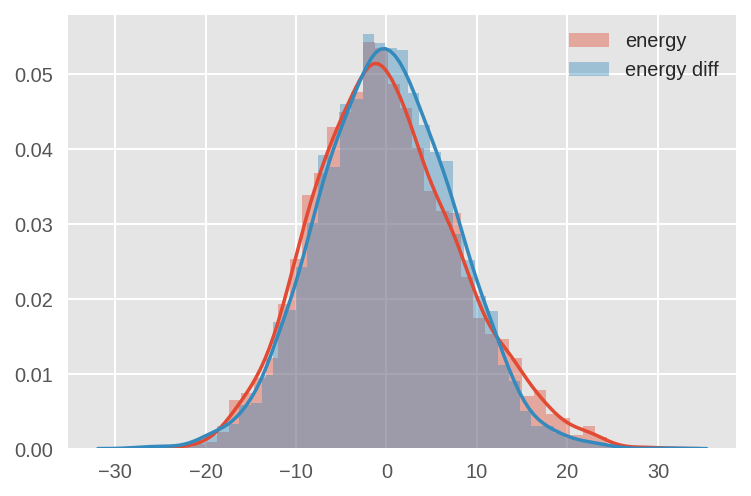

In [12]:
burnin = 1000
plot_samplerstat(burnin,trace2)

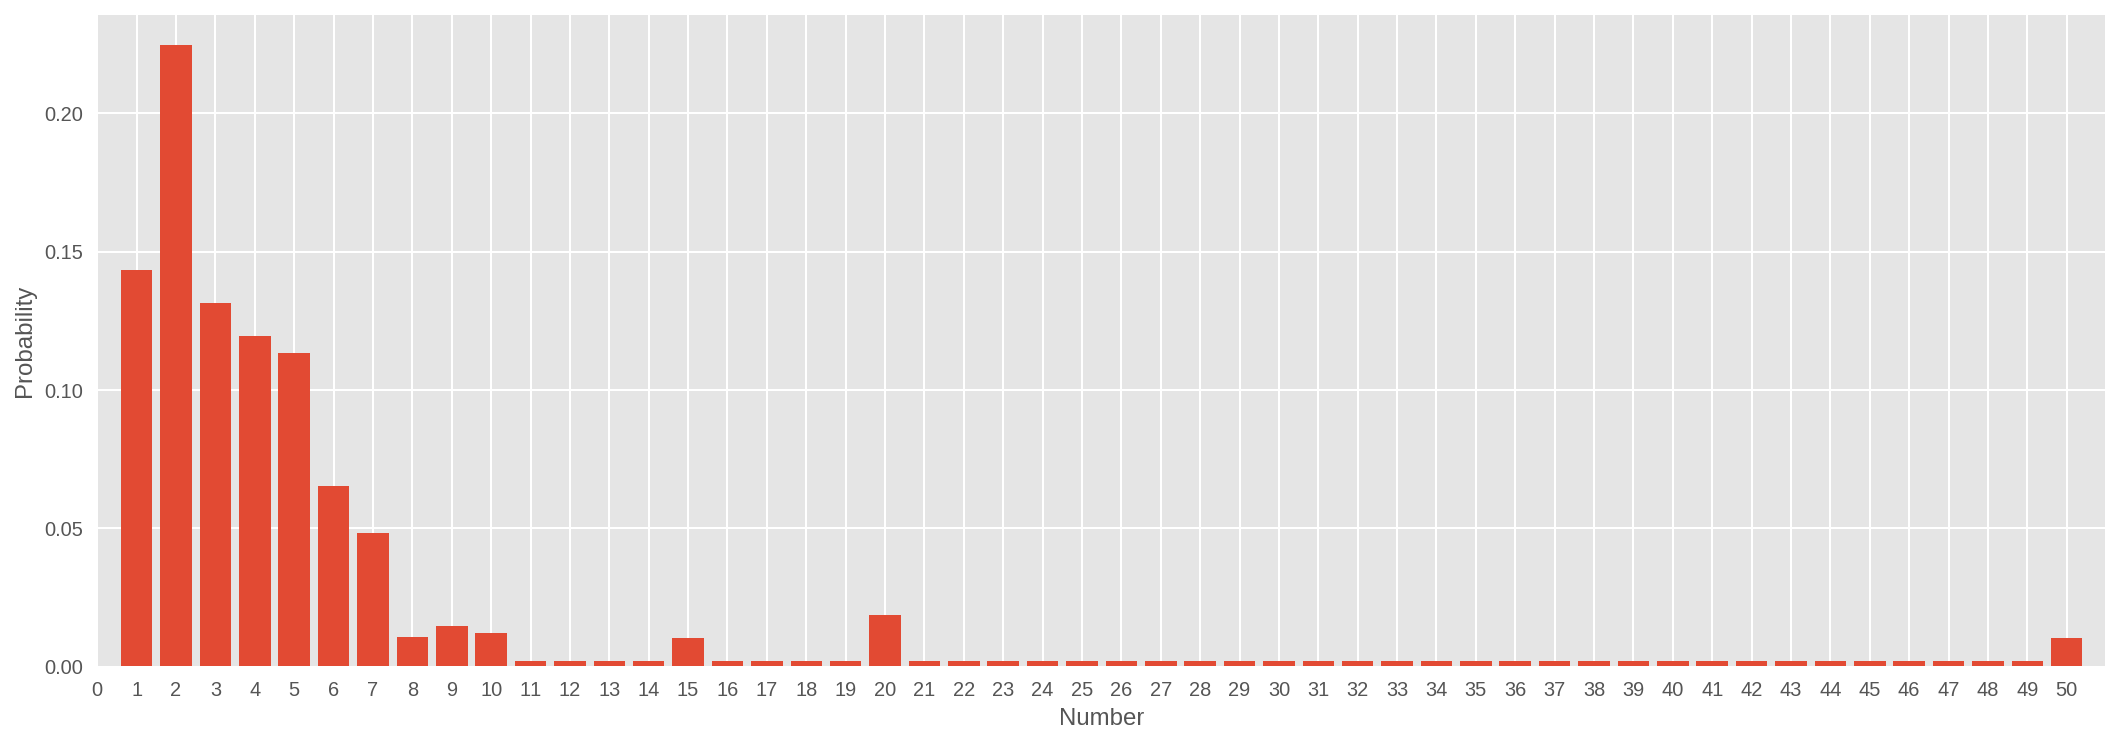

In [13]:
pitr = trace2[burnin:]['pi']
fig = plt.figure(figsize=(18, 6))
plt.bar(np.arange(50)+1, np.mean(pitr, axis=0), align='center')
plt.xlabel('Number')
plt.ylabel('Probability')
plt.xticks(np.arange(51))
plt.xlim([0, 51])
plt.show()

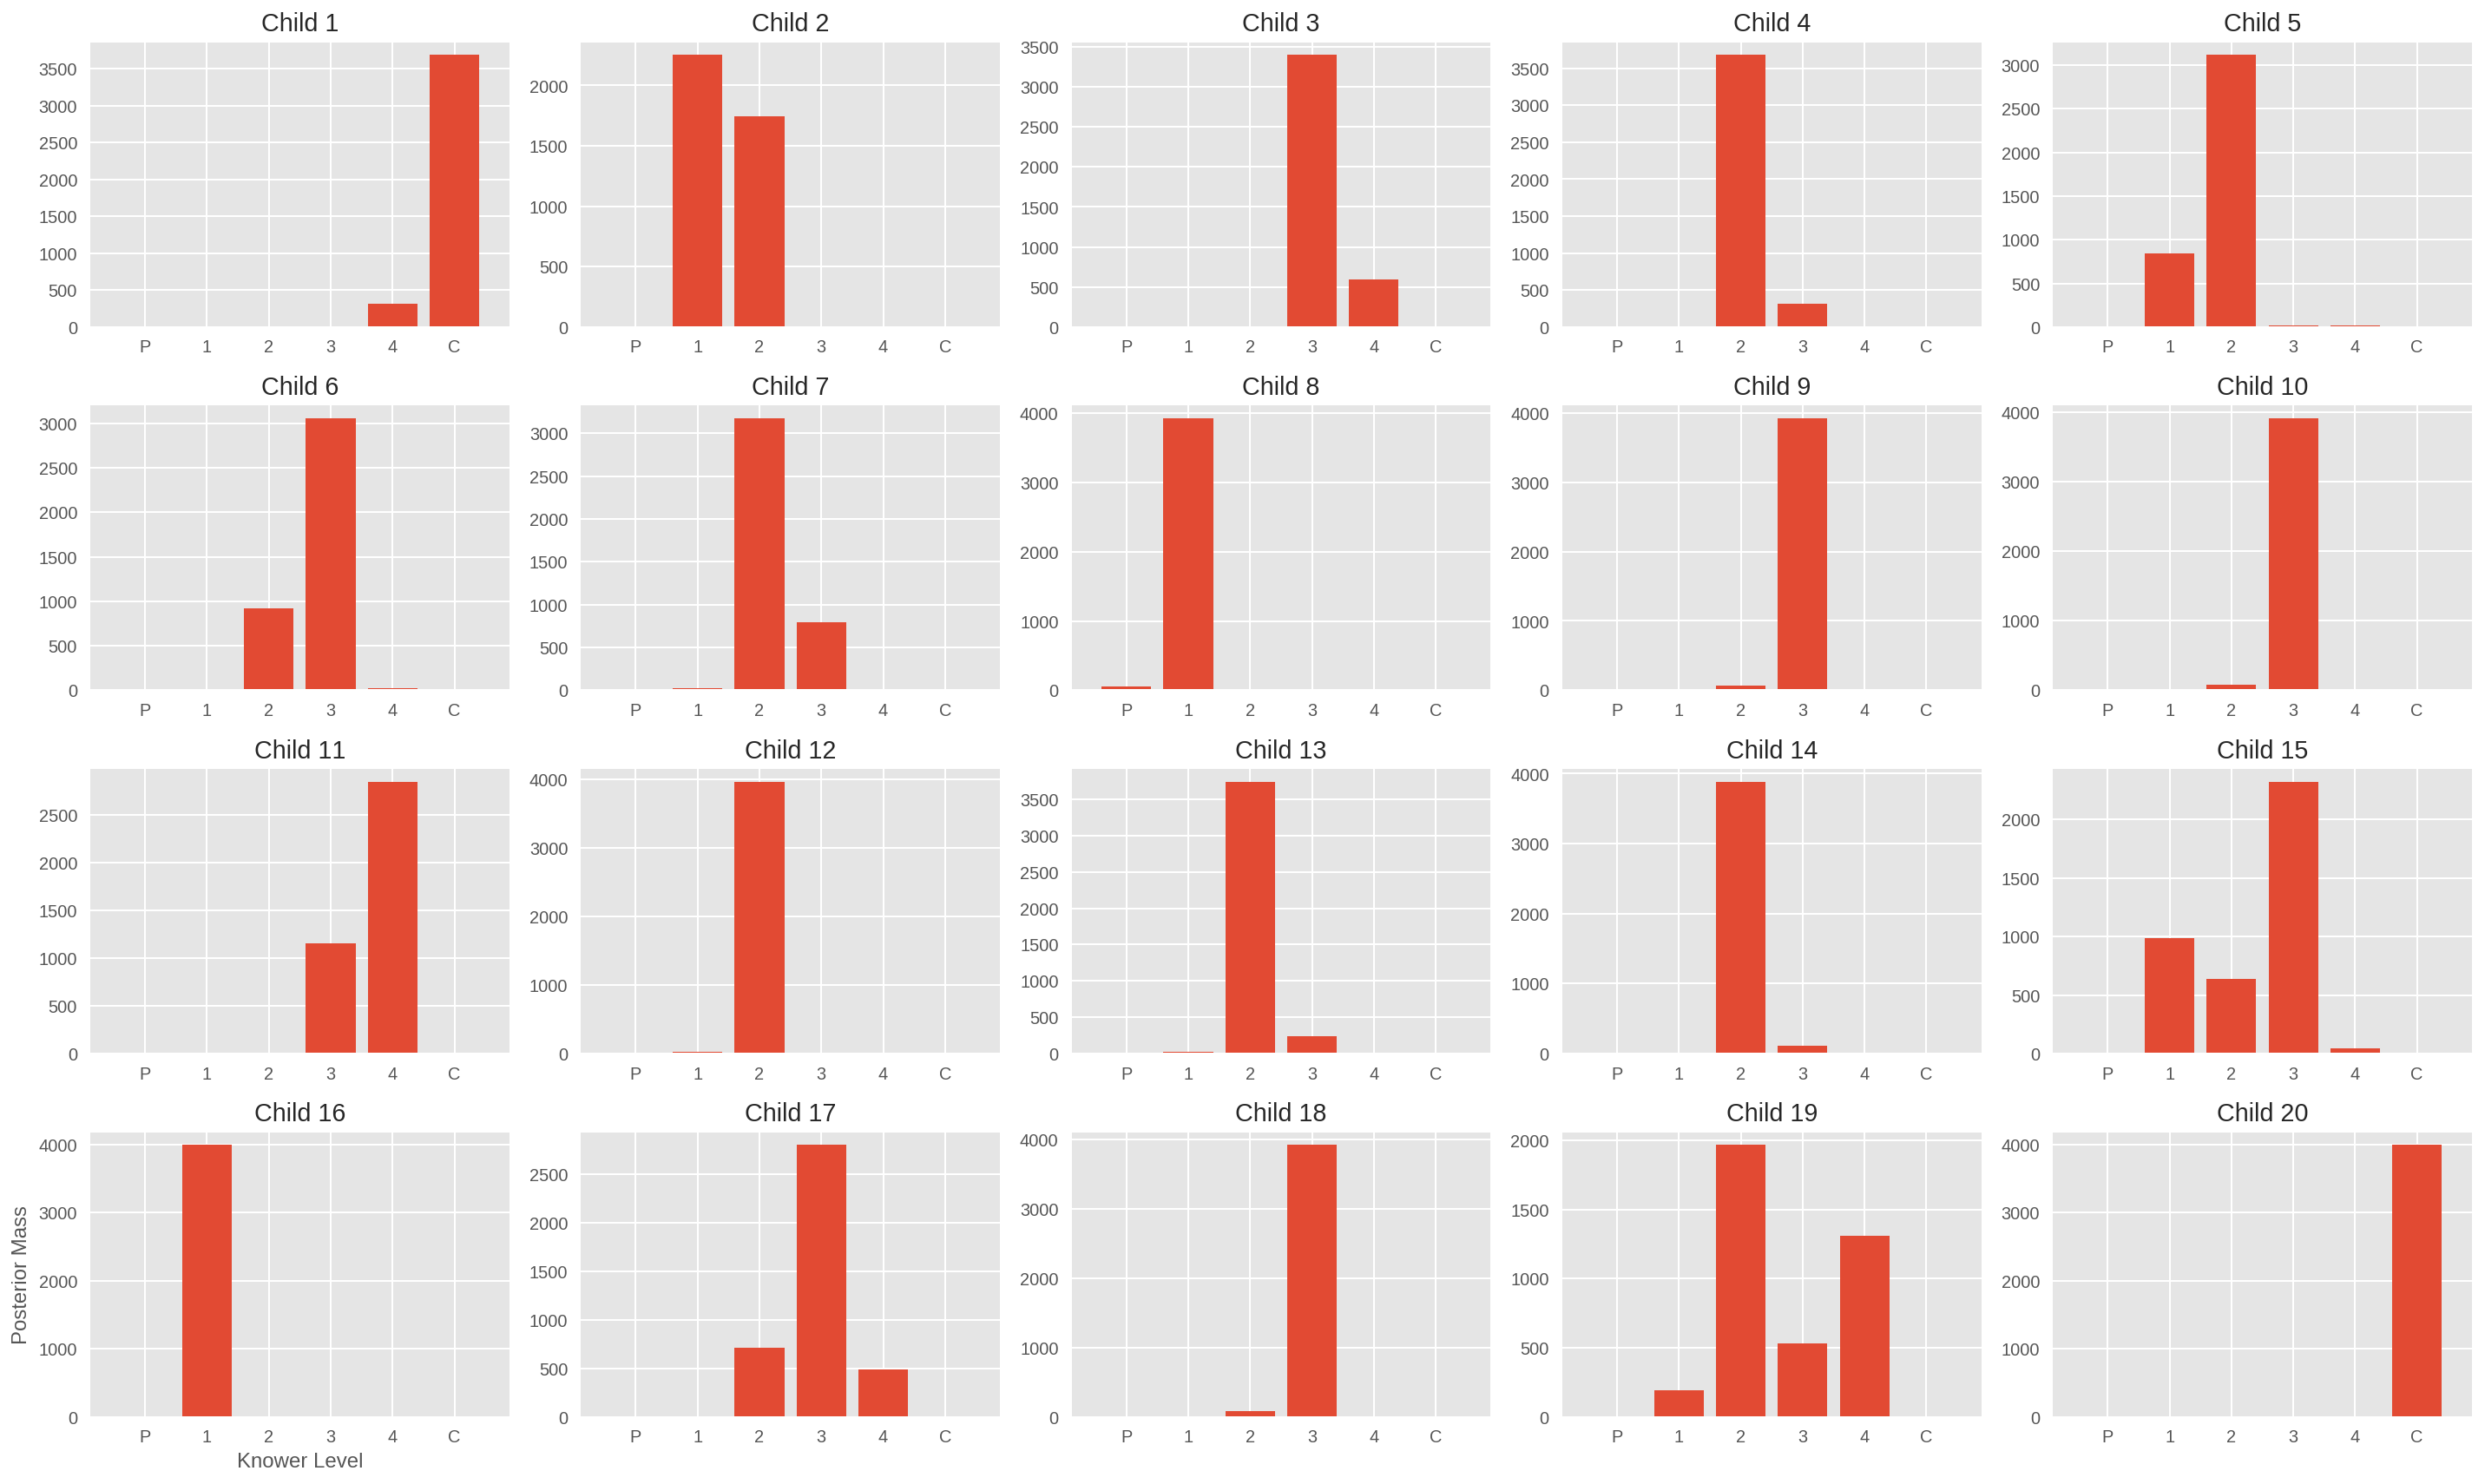

In [14]:
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(4, 5)
zitr = trace2[burnin:]['zi']
for i in range(ns):
    ax = plt.subplot(gs[i])
    bartmp = np.unique(zitr[:, i], return_counts=True)
    ax.bar(bartmp[0], bartmp[1])
    ax.set_title('Child %s'%(i+1))
    plt.xlim([-.9, 5.9])
    plt.xticks(np.arange(6), ['P', '1', '2', '3', '4', 'C'])
    
plt.subplot(gs[15])
plt.xlabel('Knower Level')
plt.ylabel('Posterior Mass')
plt.tight_layout()
plt.show()

In [15]:
# Generate posterior prediction for each knower level
zpred = np.tile(np.arange(gn)[np.newaxis, :], (nz, 1)).flatten()
z_vect = np.tile(np.arange(nz)[:, np.newaxis], (1, gn)).flatten()

nutr = trace2[burnin:]['nu']
pitr = trace2[burnin:]['pi']
tracelen = nutr.shape[0]
nsample = 500
predz = np.zeros((nsample, len(zpred)))
randlist = np.random.choice(tracelen, nsample)
caterandom = lambda p: np.asarray([np.random.choice(len(p1), p=p1) for p1 in p])
for i, idx in enumerate(randlist):
    pi1, nu1, zi1 = pitr[idx], nutr[idx], zitr[idx]
    
    nu_vec1 = np.stack([1., 1./nu1, nu1])
    piprime1 = np.multiply(nu_vec1[find5r], pi1)
    npiprime1 = piprime1 / np.sum(piprime1, axis=-1, keepdims=True)

    zi_ij_pred = npiprime1[z_vect, zpred, :]
    predz[i, :] = caterandom(zi_ij_pred)

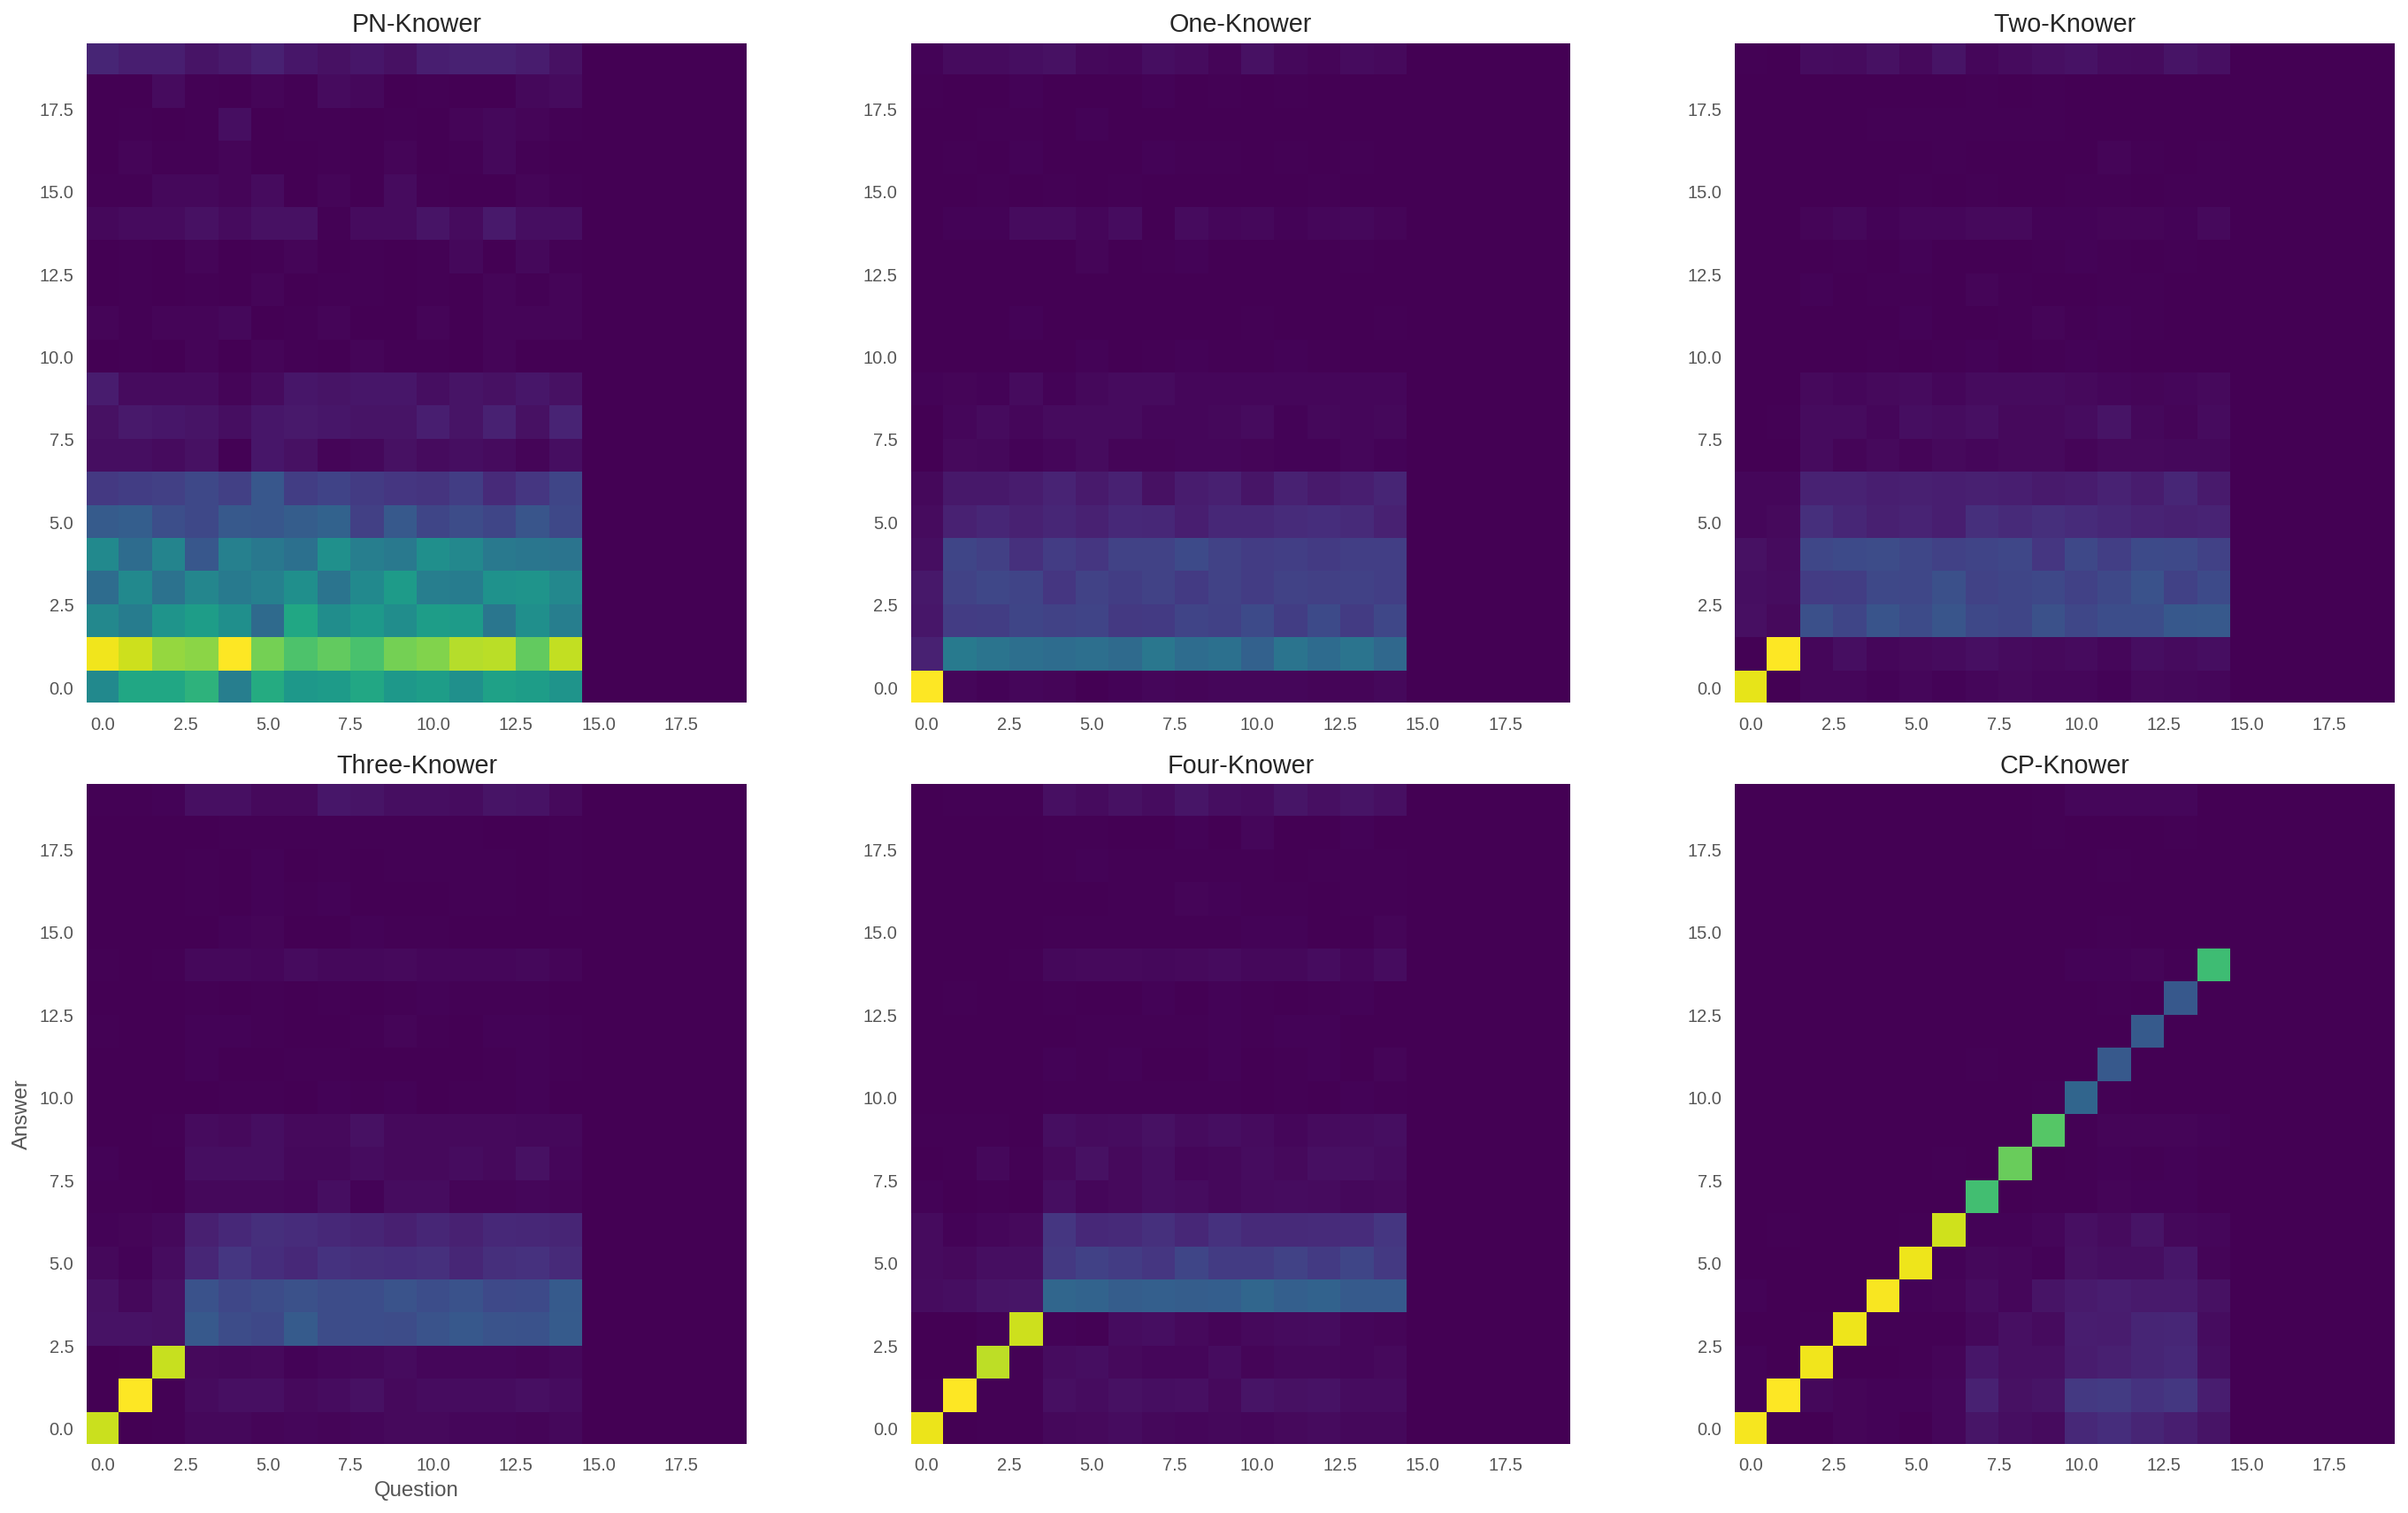

In [16]:
predz = np.reshape(predz, newshape=(nsample, nz, gn)).astype(int)

fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2, 3)
knowertype = ('PN-Knower', 'One-Knower', 'Two-Knower',
              'Three-Knower', 'Four-Knower', 'CP-Knower')
for i in range(nz):
    mattmp = np.squeeze(predz[:, i, :])
    img_ = np.zeros((fn, fn))
    for j in range(gn):
        bartmp = np.unique(mattmp[:, j], return_counts=True)
        img_[bartmp[0], j] = bartmp[1]
    ax = plt.subplot(gs[i])
    ax.imshow(img_[:20, :20], cmap='viridis', origin='lower')
    ax.grid('off')
    ax.set_title(knowertype[i])

plt.subplot(gs[3])
plt.xlabel('Question')
plt.ylabel('Answer')
plt.tight_layout()
plt.show()

## 19.3 Knower-level model for Give-N and Fast-Cards


$$ \pi^{g} \sim \text{Dirichlet}\overbrace{(1,...,1)}^{15} $$
$$ \pi^{f} \sim \text{Dirichlet}\overbrace{(1,...,1)}^{50} $$
$$ \nu^{g},\nu^{f} \sim \text{Uniform}(1,1000)$$
$$ z_{i} \sim \text{Categorical}(\frac{1}{6},...,\frac{1}{6})$$  

$$ \pi^{\prime g}_{ijk} \propto
\begin{cases}
\pi_k^g & \text{if $k \gt z_i$} \\
\nu^g \times \pi_{ijk}^g & \text{if $k \leq z_i$ and $k = q^f_{ij}$} \\
\frac{1}{\nu^g} \times \pi_{ijk}^g & \text{if $k \leq z_i$ and $k \neq q^f_{ij}$}
\end{cases}  $$  

$$ \pi^{\prime f}_{ijk} \propto
\begin{cases}
\pi_k^f & \text{if $k \gt z_i$} \\
\nu^f \times \pi_{ijk}^f & \text{if $k \leq z_i$ and $k = q^f_{ij}$} \\
\frac{1}{\nu^f} \times \pi_{ijk}^f & \text{if $k \leq z_i$ and $k \neq q^f_{ij}$}
\end{cases}  $$  

$$ a_{ij}^g \sim \text{Categorical}(\pi^{\prime g}_{ij})$$
$$ a_{ij}^f \sim \text{Categorical}(\pi^{\prime f}_{ij})$$

Assigned CategoricalGibbsMetropolis to zi
Assigned NUTS to pi_g_stickbreaking__
Assigned NUTS to nu_g_interval__
Assigned NUTS to pi_f_stickbreaking__
Assigned NUTS to nu_f_interval__
100%|██████████| 3500/3500.0 [04:42<00:00,  9.75it/s]


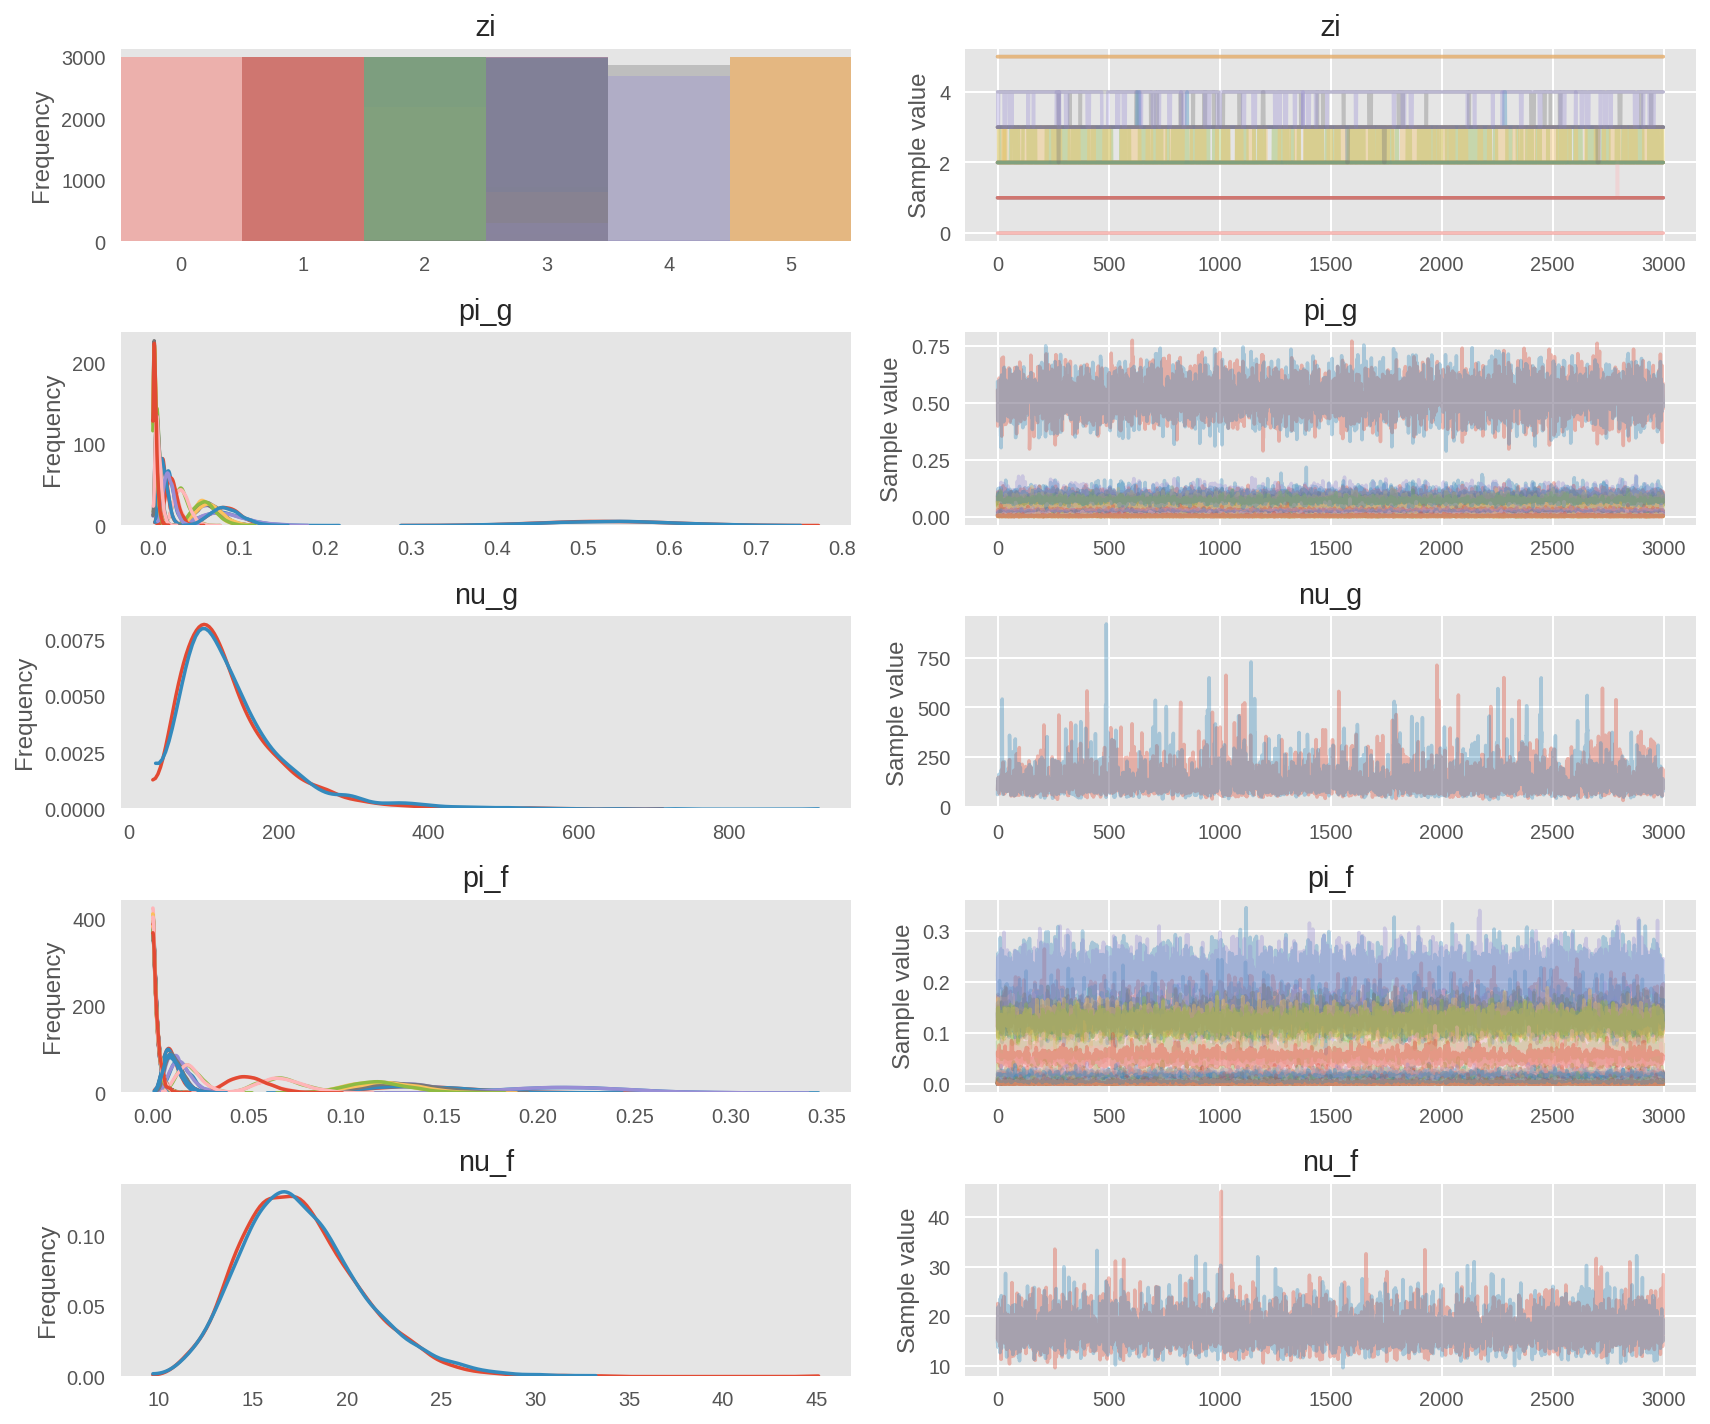

In [17]:
ind5r = ind5 - 1
ga_obs = np.asarray(ga.flatten()-1, dtype=int)
gq_obs = np.asarray(gq.flatten()-1, dtype=int)
valid_ind1 = np.where(gq_obs != -1)[0]

find5r = find5 - 1
fa_obs = np.asarray(fa.flatten()-1, dtype=int)
fq_obs = np.asarray(fq.flatten()-1, dtype=int)
valid_ind2 = np.where(fq_obs != -1)[0]

with pm.Model() as model3:
    # Knower level (same for each subject)
    zi = pm.Categorical('zi', p=np.ones(nz)/nz, shape=ns)
    
    # Give-N
    pi_g = pm.Dirichlet('pi_g', a=np.ones(gn), shape=gn)
    nug = pm.Uniform('nu_g', lower=1, upper=1000)
    nug_vec = tt.stack([1., 1./nug, nug])
    
    piprimeg = tt.mul(nug_vec[ind5r], pi_g)
    npiprimeg = piprimeg / tt.sum(piprimeg, axis=-1, keepdims=True)
    zig_vec = tt.repeat(zi, gq.shape[1])
    pig_ij = npiprimeg[zig_vec[valid_ind1], gq_obs[valid_ind1], :]
    
    agij = pm.Categorical('ag_ij', p=pig_ij, observed=ga_obs[valid_ind1])

    # Fast-Cards
    pi_f = pm.Dirichlet('pi_f', a=np.ones(fn), shape=fn)
    nuf = pm.Uniform('nu_f', lower=1, upper=1000)
    nuf_vec = tt.stack([1., 1./nuf, nuf])
    
    piprimef = tt.mul(nuf_vec[find5r], pi_f)
    npiprimef = piprimef / tt.sum(piprimef, axis=-1, keepdims=True)
    zif_vec = tt.repeat(zi, fq.shape[1])
    
    pif_ij = npiprimef[zif_vec[valid_ind2], fq_obs[valid_ind2], :]

    afij = pm.Categorical('af_ij', p=pif_ij, observed=fa_obs[valid_ind2])
    
    trace3= pm.sample(3e3, njobs=2)
    
pm.traceplot(trace3, varnames=['zi', 'pi_g', 'nu_g', 'pi_f', 'nu_f']);

The accept rate is: 0.82308
Diverge of the trace
(array([], dtype=int64),)


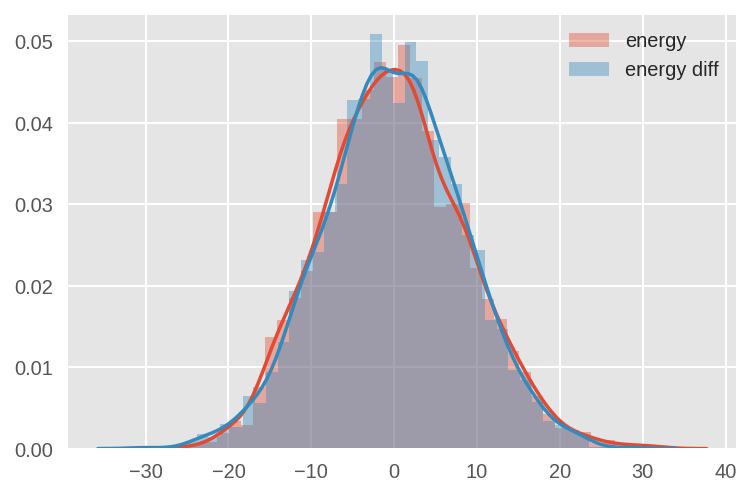

In [18]:
burnin = 1000
plot_samplerstat(burnin, trace3)

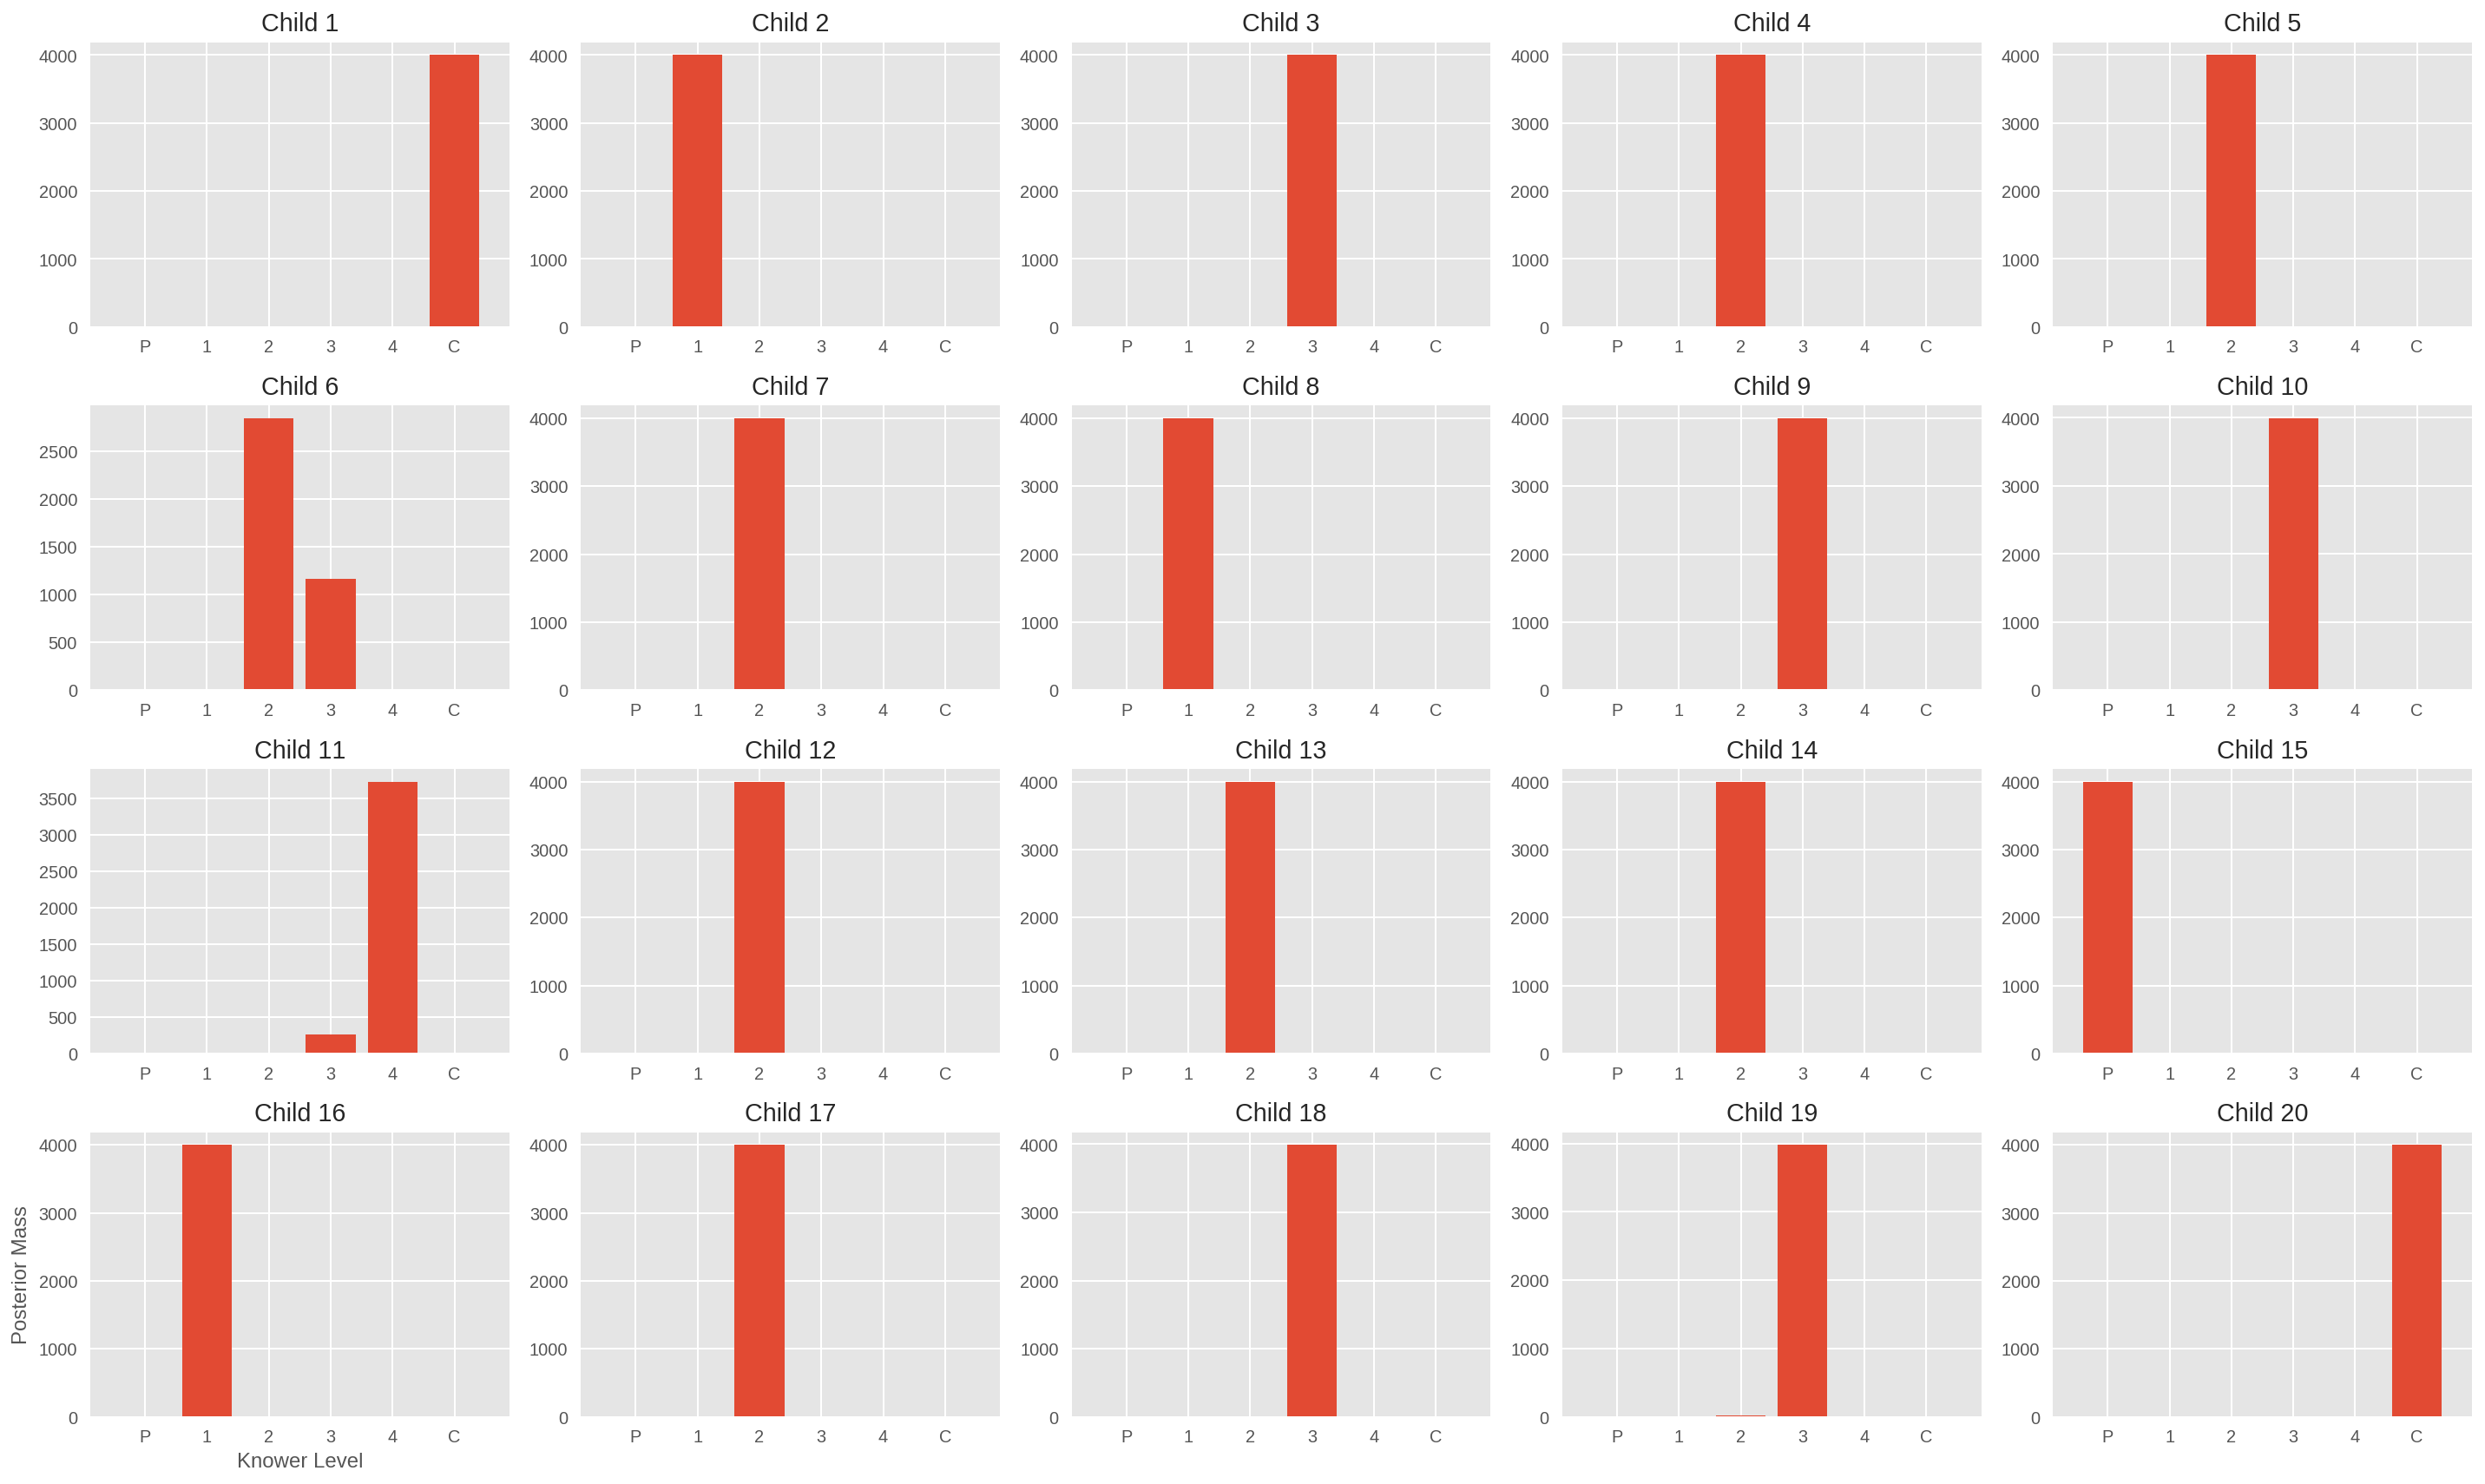

In [19]:
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(4, 5)
zitr = trace3[burnin:]['zi']
for i in range(ns):
    ax = plt.subplot(gs[i])
    bartmp = np.unique(zitr[:, i], return_counts=True)
    ax.bar(bartmp[0], bartmp[1])
    ax.set_title('Child %s'%(i+1))
    plt.xlim([-.9, 5.9])
    plt.xticks(np.arange(6), ['P', '1', '2', '3', '4', 'C'])
    
plt.subplot(gs[15])
plt.xlabel('Knower Level')
plt.ylabel('Posterior Mass')
plt.tight_layout()
plt.show()